In [54]:
import os

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["JAX_PLATFORM_NAME"] = "cuda"  # Force JAX to use CUDA

# pcx
import pcx as px
import pcx.predictive_coding as pxc
import pcx.nn as pxnn
import pcx.functional as pxf
import pcx.utils as pxu

# 3rd party
import jax
from jax import jit
import jax.numpy as jnp
import jax.numpy.linalg as jax_numpy_linalg # for expm()
import jax.scipy.linalg as jax_scipy_linalg # for slogdet()

import jax.random as random
import optax
import numpy as np
import pandas as pd
from pandas.api.types import is_float_dtype
from ucimlrepo import fetch_ucirepo 

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import timeit
from sklearn.metrics import f1_score

# own
import causal_helpers
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrices
from causal_helpers import is_dag_nx, MAE, compute_binary_adjacency, compute_h_reg, notears_dag_constraint, dagma_dag_constraint, enforce_dag
from causal_helpers import load_graph, load_adjacency_matrix
from causal_metrics import compute_F1_directed, compute_F1_skeleton, compute_AUPRC, compute_AUROC, compute_cycle_F1
from causal_metrics import compute_SHD, compute_SID, compute_ancestor_AID, compute_TEE
from connectome_cyclic_data_generator import sample_cyclic_data

# Set random seed
seed = 3 # main seed for reproducibility
set_random_seed(seed)

# causal libraries
import cdt, castle
from castle.algorithms import GOLEM, Notears, PC
from castle.algorithms.ges.ges import GES
from castle.algorithms import DirectLiNGAM, ICALiNGAM

# lingam
import lingam # for LiM model

# causal metrics
from cdt.metrics import precision_recall, SHD, SID
from castle.metrics import MetricsDAG
from castle.common import GraphDAG
from causallearn.graph.SHD import SHD as SHD_causallearn

In [2]:
import pandas as pd
#   # fetch dataset 
# abalone = fetch_ucirepo(id=1) 
  
# # data (as pandas dataframes) 
# X = abalone.data.features
# y = abalone.data.targets
  
# # metadata 
# #print(abalone.metadata) 

# # now merge X and y to create a single dataframe and give the columns the correct names using abalone.variables.name.values
# df = pd.concat([X, y], axis=1)
# df.columns = abalone.variables.name.values.tolist()
# print(df.head())
# print()
# # show # of unique values in each column
# print(df.nunique())
# # finally convert the Rings variable to a binary variable by setting the threshold to mean(rings)
# df['Rings'] = df['Rings'] > df['Rings'].mean()
# # then convert to integer
# df['Rings'] = df['Rings'].astype(int)
# # also replace the values in Sex with integers
# df['Sex'] = df['Sex'].map({'M': 0, 'F': 1, 'I': 2})

# # now show the first 5 rows of the dataframe
# print(df.head())

# # Create a boolean list for continuous variables (any float dtype)
# is_cont_node = df.dtypes.map(is_float_dtype).tolist()

# # Print the result
# print(is_cont_node)

# # plot the distribution of all variables in the dataframe
# df.hist(figsize=(15, 10))
# plt.show()

# path to mixed_confounding data
path = '/share/amine.mcharrak/mixed_data_final/custom_mixed_confounding_softplus/'

# file name adjacency matrix in csv format
mixed_confounding_adjacency_matrix = 'adj_matrix.csv'
# file name observational data in csv format
mixed_confounding_obs_data = 'train.csv'

# load adjacency matrix and data as pandas dataframe, both files have no header
adj_matrix = pd.read_csv(path + mixed_confounding_adjacency_matrix, header=None)
X_df = pd.read_csv(path + mixed_confounding_obs_data, header=None)
weighted_adj_matrix = pd.read_csv(path + 'W_adj_matrix.csv', header=None)

B_true = adj_matrix.values
X = X_df.values
W_true = weighted_adj_matrix.values

In [3]:
X_df.head()
# show unique values in each column
print(X_df.nunique())
# Determine if each variable is continuous or discrete based on the number of unique values
is_cont_node = np.array([True if X_df[col].nunique() > 2 else False for col in X_df.columns])
is_cont_node = is_cont_node.tolist()
print(is_cont_node)

0        2
1     4000
2        2
3     4000
4        2
5        2
6     4000
7        2
8     4000
9     4000
10    4000
11    4000
dtype: int64
[False, True, False, True, False, False, True, False, True, True, True, True]


In [ ]:
# # ## Load the actual connectome data

# # %%
# # load the weighted adjacency matrices for ER and connectome

# # Specify the folder where the adjacency matrices were saved
# folder = '../data/'

# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_cyclic = '/home/amine.mcharrak/connectome/data/'
# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_acyclic = '/home/amine.mcharrak/connectome/data/'

# # Example usage to load the saved adjacency matrices
# # G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
# # G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
# # ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
# # ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# # Change name of the connectome adjacency matrix to C and C_dag
# # C = G_A_init_t_ordered_adj_matrix
# # C_dag = G_A_init_t_ordered_dag_adj_matrix

# # Now ensure that both DAG adjacency matrices are binary, if they aren't already
# # ER_dag_bin = (ER_dag != 0).astype(int)
# # C_dag_bin = (C_dag != 0).astype(int)

# # ER_true = ER_dag_bin
# # C_true = C_dag_bin

# # %% [markdown]
# # ## Create data to debug and implement the pcax version of NOTEARS

# # %%
# # actual data
# B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# # B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4
# # debugging data
# # B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2


# # B_true = C_dag_bin # if you want to use the connectome-based DAG # best
# #B_true = ER_dag_bin # if you want to use the ER-based DAG

# #B_true = simulate_dag(d=5, s0=10, graph_type='ER') # ER2
# #B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# #B_true = simulate_dag(d=50, s0=100, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=279, s0=558, graph_type='ER') # ER2

# # create SF2 graph and SF4 graph with d=10 nodes
# #B_true = simulate_dag(d=10, s0=20, graph_type='SF') # SF2
# #B_true = simulate_dag(d=10, s0=40, graph_type='SF') # SF4
# #B_true = simulate_dag(d=100, s0=400, graph_type='SF') # SF4

# # create ER2 and ER4 graphs with d=100 nodes
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4

# # create equivalent ER4 and ER6 graphs
# #B_true = simulate_dag(d=279, s0=1116, graph_type='ER') # ER4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='ER') # ER6

# # create equivalent SF4 and SF6 graphs
# #B_true = simulate_dag(d=100, s0=600, graph_type='SF') # SF6
# #B_true = simulate_dag(d=279, s0=1116, graph_type='SF') # SF4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='SF') # SF6

# # create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
# #B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# # examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800

# # create the weighted adjacency matrix based on the binary adjacency matrix
# #W_true = simulate_parameter(B_true, connectome=True)
# #W_true = simulate_parameter(B_true)

# # sample data from the linear SEM
# # actual data
# #X = simulate_linear_sem(W_true, n=10000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=10000, sem_type='uniform')
# # for debugging
# #X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=2500, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=6250, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=50000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=100000, sem_type='gauss') # 1000*(279**2)/(20**2) = 194602

# # load the cyclic integer weighted connectome data adjacency matrix
# #B_true_weighted = load_adjacency_matrix(os.path.join(folder_cyclic, 'A_init_t_ordered_adj_matrix_with_cycles.npy'))
# #X, W_true = sample_cyclic_data(B_true_weighted, n_samples=10000, noise_type='non-gaussian')
# #B_true = (W_true != 0).astype(int)

# # load the acyclic integer weighted connectome data adjacency matrix
# # B_true_weighted = load_adjacency_matrix(os.path.join(folder_acyclic, 'A_init_t_ordered_adj_matrix_no_cycles.npy'))
# # print("B_true_weighted:\n", np.array_str(B_true_weighted, precision=4, suppress_small=True))

# # A: use this for regular DAGs
# W_true = simulate_parameter(B_true)

# # B: use this for connectome-based DAGs
# #W_true = simulate_parameter(B_true_weighted, connectome=True)
# #B_true = (W_true != 0).astype(int)

# # some print statements to check the values of W_true
# print("W_true:\n", np.array_str(W_true, precision=4, suppress_small=True))
# print("Mean of W_true:", np.mean(W_true))
# print("Variance of W_true:", np.var(W_true))
# print("Max value in W_true:", np.max(W_true))
# print("Min value in W_true:", np.min(W_true))

# # sample data from the linear SEM
# X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')

# # now standardized data, where each variable is normalized to unit variance
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

# # NOTE: you may not write positional arguments after keyword arguments. 
# # That is, the values that you are passing positionally have to come first!

# # create a dataset using the simulated data
# # NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# # NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# # Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# # we should expect to use that many samples actually to be able to learn the graph in a comparable way.
# #dataset = IIDSimulation(W=W_true, n=25000, method='linear', sem_type='gauss')
# #true_dag, X = dataset.B, dataset.X

In [4]:
# print how many non-zero entries are in the true DAG
print(f"Number of non-zero entries in the true DAG: {np.count_nonzero(B_true)}")

Number of non-zero entries in the true DAG: 15


In [5]:
class Complete_Graph(pxc.EnergyModule):
    def __init__(self, input_dim: int, n_nodes: int, has_bias: bool = False, is_cont_node: list = None, seed: int = 0, stddev: float = 1.0) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)  # Ensure input_dim is static
        self.n_nodes = px.static(n_nodes)  # Keep n_nodes as a static value
        self.has_bias = has_bias
        self.is_cont_node = is_cont_node
        self.stddev = stddev

        # Initialize a single linear layer for the weights and wrap it in a list
        self.layers = [pxnn.Linear(n_nodes, n_nodes, bias=has_bias)] # vanilla initialization is uniform(-stdv, stdv) with stdv = 1/sqrt(n_nodes), here n_nodes = 12, thus stdv = 1/sqrt(12) = 0.2887
        
        #stddev = jnp.sqrt(0.01) # this equals 0.1 (default would have been 0.2887)
        #stddev = 1/n_nodes
        stddev = self.stddev

        # Use the seed to generate a JAX key
        key = random.PRNGKey(seed)

        # split the key to ensure randomness
        #key, subkey = random.split(key) # use if more than one key is needed, ie if we do more than one random operation

        new_weight_matrix = random.normal(key, shape=(n_nodes, n_nodes)) * stddev # option 1 using normal distribution
        #new_weight_matrix = random.uniform(key, shape=(n_nodes, n_nodes), minval=-stddev, maxval=stddev) # option 2 using uniform distribution

        # Step 3: Replace diagonal elements with 0
        for i in range(n_nodes):
            new_weight_matrix = new_weight_matrix.at[i, i].set(0.0)

        # Step 5: Update the weight matrix
        self.layers[0].nn.weight.set(new_weight_matrix)

        # Initialize vodes based on is_cont_node
        if is_cont_node is None:
            is_cont_node = [True] * n_nodes  # Default to all continuous nodes if not provided

        self.vodes = []
        for is_cont in is_cont_node:
            if is_cont:
                self.vodes.append(pxc.Vode())
            else:
                self.vodes.append(pxc.Vode(pxc.bce_energy))

    def freeze_nodes(self, freeze=True):
        """Freeze or unfreeze all vodes in the model."""
        for vode in self.vodes:
            vode.h.frozen = freeze

    def are_vodes_frozen(self):
        """Check if all vodes in the model are frozen."""
        return all(hasattr(vode.h, 'frozen') and vode.h.frozen for vode in self.vodes)
    
    def get_W(self):
        """This function returns the weighted adjacency matrix based on the linear layer in the model."""
        W = self.layers[0].nn.weight.get()
        W_T = W.T
        return W_T

    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()

        if x is not None:
            # Initialize nodes with given data
            reshaped_x = x.reshape(n_nodes, -1)  # Infer input_dim from x
            
            # Print the shape of reshaped_x[0] when x is not None
            print("The shape of reshaped_x[0] when x is not None is: ", reshaped_x[0].shape)

            for i in range(n_nodes):
                self.vodes[i](reshaped_x[i])

        else:
            # Stack current state of vodes into a matrix of shape (n_nodes, input_dim)
            x_ = jnp.vstack([vode.get('h') for vode in self.vodes])

            # Print the shape of x_ when x is None
            print("The shape of x_ when x is None is: ", x_.shape)

            # Apply the linear transformation
            output = self.layers[0](x_)

            # Print the shape of output when x is None
            print("The shape of output when x is None is: ", output.shape)

            # Update the vodes with the output
            for i in range(n_nodes):
                self.vodes[i](output[i])

        # Stack the final state of vodes for output
        output = jnp.vstack([vode.get('h') for vode in self.vodes])

        # Print the shape of the output
        print("The shape of the output is: ", output.shape)

        return output

# Usage
input_dim = 1
n_samples = X.shape[0]
n_nodes = X.shape[1]
stddev = 1/n_nodes

#model = Complete_Graph(input_dim, n_nodes, has_bias=True, is_cont_node=is_cont_node, seed=seed, stddev=stddev)
model = Complete_Graph(input_dim, n_nodes, has_bias=True, is_cont_node=is_cont_node, seed=seed, stddev=stddev)
# Get weighted adjacency matrix
W = model.get_W()
print("This is the weighted adjacency matrix:\n", W)
print()
print("The shape of the weighted adjacency matrix is: ", W.shape)
print()
#print(model)
print()

# Check if all nodes are frozen initially
print("Initially, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Freezing all nodes
print("Freezing all nodes...")
model.freeze_nodes(freeze=True)
print()

# Check if all nodes are frozen after freezing
print("After freezing, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Unfreezing all nodes
print("Unfreezing all nodes...")
model.freeze_nodes(freeze=False)
print()

# Check if all nodes are frozen after unfreezing
print("After unfreezing, are all nodes frozen?:", model.are_vodes_frozen())

This is the weighted adjacency matrix:
 [[ 0.000e+00 -1.652e-02 -1.135e-01  1.656e-02 -9.668e-02  1.247e-01
  -7.993e-02  3.851e-03 -8.403e-02 -1.082e-01  5.787e-02  4.711e-02]
 [ 4.275e-02  0.000e+00 -5.064e-03  1.076e-01 -2.217e-01 -1.396e-01
   6.265e-02  7.265e-02 -3.915e-02  2.959e-02  1.988e-02  2.286e-01]
 [ 3.986e-02 -9.573e-02  0.000e+00 -1.420e-01 -5.800e-02 -2.813e-02
  -1.451e-01 -1.970e-01  4.638e-02 -3.449e-02 -1.291e-02  1.237e-02]
 [-1.576e-01  1.351e-02 -3.867e-02  0.000e+00 -7.187e-02  7.598e-02
   8.267e-02 -5.624e-02  3.562e-02 -3.590e-02  7.804e-02 -9.856e-02]
 [-9.859e-02  1.893e-02  1.967e-02 -6.189e-02  0.000e+00  1.267e-02
   2.756e-02 -6.668e-02 -6.614e-02 -9.552e-02 -1.078e-01 -4.513e-02]
 [ 4.113e-02 -3.669e-02 -3.228e-02  2.690e-02 -7.221e-02  0.000e+00
   2.820e-02  1.669e-01  1.916e-02 -3.208e-02  1.131e-01 -4.585e-02]
 [-2.899e-02  2.942e-03  1.710e-02  3.010e-02  5.665e-02  6.054e-02
   0.000e+00 -9.370e-02  6.552e-02 -9.582e-02 -2.271e-02 -9.942e-02]
 

In [6]:
model.is_cont_node

[False, True, False, True, False, False, True, False, True, True, True, True]

In [7]:
# TODO: make the below params global or input to the functions in which it is used.
w_learning_rate = 1e-3 # Notes: 5e-1 is too high
h_learning_rate = 1e-4
T = 1

nm_epochs = 1000 # not much happens after 2000 epochs
every_n_epochs = 500
batch_size = 128


# {'fdr': 0.0667, 'tpr': 0.9333, 'fpr': 0.0196, 'shd': 1, 'nnz': 15, 'precision': 0.9333, 'recall': 0.9333, 'F1': 0.9333, 'gscore': 0.8667}
# bs_128_lrw_0.001_lrh_0.0001_lamh_10000.0_laml1_1.0_epochs_2000 gives F1 score of 0.9333
# NOTE THIS USES EPSILON=1e-8 FOR THE NORMALIZATION OF THE REGULARIZATION TERMS
# lam_h = 1e4
# lam_l1 = 1e0

lam_h = 1e4
lam_l1 = 1e0

# Create a file name string for the hyperparameters
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"
print("Name of the experiment: ", exp_name)

# Training an1d evaluation functions
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    return model(x)

# @pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, 0), axis_name="batch") # if only one output
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, None, None, None, 0), axis_name="batch") # if multiple outputs
def energy(*, model: Complete_Graph):

    print("Energy: Starting computation")
    x_ = model(None)
    print("Energy: Got model output")
    
    W = model.get_W()
    # Dimensions of W
    d = W.shape[0]
    print(f"Energy: Got W (shape: {W.shape}) and d: {d}")

    # PC energy term
    pc_energy = jax.lax.pmean(model.energy(), axis_name="batch")
    print(f"Energy: PC energy term: {pc_energy}")

    # L1 regularization using adjacency matrix (scaled by Frobenius norm)
    l1_reg = jnp.sum(jnp.abs(W)) / (jnp.linalg.norm(W, ord='fro') + 1e-8)
    #l1_reg = jnp.sum(jnp.abs(W)) / d
    print(f"Energy: L1 reg term: {l1_reg}")

    # DAG constraint (stable logarithmic form)
    #h_reg = notears_dag_constraint(W)
    #h_reg = notears_dag_constraint(W)/ (jnp.sqrt(d) + 1e-8)
    #h_reg = notears_dag_constraint(W) / d  # with normalization

    #h_reg = dagma_dag_constraint(W)
    h_reg = dagma_dag_constraint(W) / (jnp.sqrt(d) + 1e-8)
    #h_reg = dagma_dag_constraint(W) / d  # with normalization
    print(f"Energy: DAG constraint term: {h_reg}")
        
    # Combined loss
    obj = pc_energy + lam_h * h_reg + lam_l1 * l1_reg
    print(f"Energy: Final objective: {obj}")

    # Ensure obj is a scalar, not a (1,) array because JAX's grad and value_and_grad functions are designed
    # to compute gradients of *scalar-output functions*
    obj = obj.squeeze()  # explicitly converte the (1,) array (obj) to a scalar of shape ()  
    
    return obj, pc_energy, h_reg, l1_reg, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    print("1. Starting train_on_batch")  

    model.train()
    print("2. Model set to train mode")

    model.freeze_nodes(freeze=True)
    print("3. Nodes frozen")

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        print("4. Doing forward for initialization")
        forward(x, model=model)
        print("5. After forward for initialization")

    """
    # The following code might not be needed as we are keeping the vodes frozen at all times
    # Reinitialize the optimizer state between different batches
    optim_h.init(pxu.M(pxc.VodeParam)(model))

    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, x_), g = pxf.value_and_grad(
                pxu.M(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(model=model)
        optim_h.step(model, g["model"], True)
    """

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("6. Before computing gradients")
        (obj, (pc_energy, h_reg, l1_reg, x_)), g = pxf.value_and_grad(
            pxu.M(pxnn.LayerParam).to([False, True]), 
            has_aux=True
        )(energy)(model=model) # pxf.value_and_grad returns a tuple structured as ((value, aux), grad), not as six separate outputs.
        
        print("7. After computing gradients")
        #print("Gradient structure:", g)

        print("8. Before zeroing out the diagonal gradients")
        # Zero out the diagonal gradients using jax.numpy.fill_diagonal
        weight_grads = g["model"].layers[0].nn.weight.get()
        weight_grads = jax.numpy.fill_diagonal(weight_grads, 0.0, inplace=False)
        # print the grad values using the syntax jax.debug.print("🤯 {x} 🤯", x=x)
        #jax.debug.print("{weight_grads}", weight_grads=weight_grads)
        g["model"].layers[0].nn.weight.set(weight_grads)
        print("9. After zeroing out the diagonal gradients")

        
    print("10. Before optimizer step")
    optim_w.step(model, g["model"])
    #optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])
    print("11. After optimizer step")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("12. Before final forward")
        forward(None, model=model)
        e_avg_per_sample = model.energy()
        print("13. After final forward")

    model.freeze_nodes(freeze=False)
    print("14. Nodes unfrozen")

    return pc_energy, l1_reg, h_reg, obj

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    batch_pc_energies = []
    batch_l1_regs = []
    batch_h_regs = []
    batch_objs = []
    
    for batch in dl:
        pc_energy, l1_reg, h_reg, obj = train_on_batch(
            T, batch, model=model, optim_w=optim_w, optim_h=optim_h
        )
        batch_pc_energies.append(pc_energy)
        batch_l1_regs.append(l1_reg)
        batch_h_regs.append(h_reg)
        batch_objs.append(obj)

    W = model.get_W()

    # Compute epoch averages
    epoch_pc_energy = jnp.mean(jnp.array(batch_pc_energies))
    epoch_l1_reg = jnp.mean(jnp.array(batch_l1_regs))
    epoch_h_reg = jnp.mean(jnp.array(batch_h_regs))
    epoch_obj = jnp.mean(jnp.array(batch_objs))
    
    return W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj

# %%
# for reference compute the MAE, SID, and SHD between the true adjacency matrix and an all-zero matrix and then print it
# this acts as a baseline for the MAE, SID, and SHD similar to how 1/K accuracy acts as a baseline for classification tasks where K is the number of classes

W_zero = np.zeros_like(W_true)
print("MAE between the true adjacency matrix and an all-zero matrix: ", MAE(W_true, W_zero))
print("SHD between the true adjacency matrix and an all-zero matrix: ", SHD(B_true, compute_binary_adjacency(W_zero)))
#print("SID between the true adjacency matrix and an all-zero matrix: ", SID(W_true, W_zero))

# %%
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )


# Create the custom dataset
dataset = CustomDataset(X)

# Create the custom dataset with standardized data
#dataset_std = CustomDataset(X_std)

# Create the dataloader
dl = TorchDataloader(dataset, batch_size=batch_size, shuffle=True)
######## OR ########
#dl = TorchDataloader(dataset_std, batch_size=batch_size, shuffle=True)

# %%
# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jnp.zeros((batch_size, model.n_nodes.get())), model=model)
    optim_h = pxu.Optim(lambda: optax.sgd(h_learning_rate))

    """
    optim_w = pxu.Optim(
    optax.chain(
        optax.clip_by_global_norm(clip_value),  # Clip gradients by global norm
        optax.sgd(w_learning_rate)  # Apply SGD optimizer
    ),
    pxu.M(pxnn.LayerParam)(model)  # Masking the parameters of the model
)
    """
    #optim_w = pxu.Optim(lambda: optax.adam(w_learning_rate), pxu.M(pxnn.LayerParam)(model))
    optim_w = pxu.Optim(lambda: optax.adamw(w_learning_rate, nesterov=True), pxu.M(pxnn.LayerParam)(model))

Name of the experiment:  bs_128_lrw_0.001_lrh_0.0001_lamh_10000.0_laml1_1.0_epochs_1000
MAE between the true adjacency matrix and an all-zero matrix:  0.1511739630736288
SHD between the true adjacency matrix and an all-zero matrix:  15.0
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (12, 1)


In [8]:
# Initialize lists to store differences and energies
MAEs = []
SHDs = []
F1s = []
pc_energies = []
l1_regs = []
h_regs = []
objs = []

# Calculate the initial MAE, SID, and SHD

W_init = model.get_W()
B_init = compute_binary_adjacency(W_init)

MAE_init = MAE(W_true, W_init)
print(f"Start difference (cont.) between W_true and W_init: {MAE_init:.4f}")

SHD_init = SHD(B_true, B_init)
print(f"Start SHD between B_true and B_init: {SHD_init:.4f}")

F1_init = compute_F1_directed(B_true, B_init)
print(f"Start F1 between B_true and B_init: {F1_init:.4f}")

# print the values of the diagonal of the initial W
print("The diagonal of the initial W: ", jnp.diag(W_init))

# Start timing
start_time = timeit.default_timer()

# Training loop
with tqdm(range(nm_epochs), position=0, leave=True) as pbar:
    for epoch in pbar:
        # Train for one epoch using the dataloader
        W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj = train(dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        
        # Extract the weighted adjacency matrix W and compute the binary adjacency matrix B
        W = np.array(W)
        B = compute_binary_adjacency(W)

        # Compute metrics every n epochs
        if (epoch + 1) % every_n_epochs == 0 or epoch == 0:
            MAEs.append(float(MAE(W_true, W)))
            SHDs.append(float(SHD(B_true, compute_binary_adjacency(W), double_for_anticausal=False)))
            F1s.append(float(compute_F1_directed(B_true, B)))
            pc_energies.append(float(epoch_pc_energy))
            l1_regs.append(float(epoch_l1_reg))
            epoch_h_reg_raw = compute_h_reg(W)
            h_regs.append(float(epoch_h_reg_raw))
            objs.append(float(epoch_obj))

            # Update progress bar with the current status
            pbar.set_description(f"MAE: {MAEs[-1]:.4f}, F1: {F1s[-1]:.4f}, SHD: {SHDs[-1]:.4f} || PC Energy: {pc_energies[-1]:.4f}, L1 Reg: {l1_regs[-1]:.4f}, H Reg: {h_regs[-1]:.4f}, Obj: {objs[-1]:.4f}")


# End timing
end_time = timeit.default_timer()

# Print the average time per epoch
average_time_per_epoch = (end_time - start_time) / nm_epochs
print(f"An epoch (with compiling and testing) took on average: {average_time_per_epoch:.4f} seconds")
# print the values of the diagonal of the final W
print("The diagonal of the final W: ", jnp.diag(model.get_W()))


# print in big that training is done
print("\n\n ###########################  Training is done  ########################### \n\n")

Start difference (cont.) between W_true and W_init: 0.1999
Start SHD between B_true and B_init: 15.0000
Start F1 between B_true and B_init: nan
The diagonal of the initial W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


invalid value encountered in scalar divide


  0%|          | 0/1000 [00:00<?, ?it/s]

1. Starting train_on_batch
2. Model set to train mode
3. Nodes frozen
4. Doing forward for initialization
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (12, 1)
5. After forward for initialization
6. Before computing gradients
Energy: Starting computation
The shape of x_ when x is None is:  (12, 1)
The shape of output when x is None is:  (12, 12)
The shape of the output is:  (12, 1)
Energy: Got model output
Energy: Got W (shape: (12, 12)) and d: 12
Energy: PC energy term: Traced<ShapedArray(float64[1])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[1])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[1])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f3635278760>, in_tracers=(Traced<ShapedArray(float64[1]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float64[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7f36

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Energy: DAG constraint term: Traced<ShapedArray(float64[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f36351b82c0>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float64[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7f3635159fd0; to 'JaxprTracer' at 0x7f363515a890>], out_avals=[ShapedArray(float64[])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=<jax._src.source_info_ut

invalid value encountered in scalar divide


An epoch (with compiling and testing) took on average: 0.0391 seconds
The diagonal of the final W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


 ###########################  Training is done  ########################### 




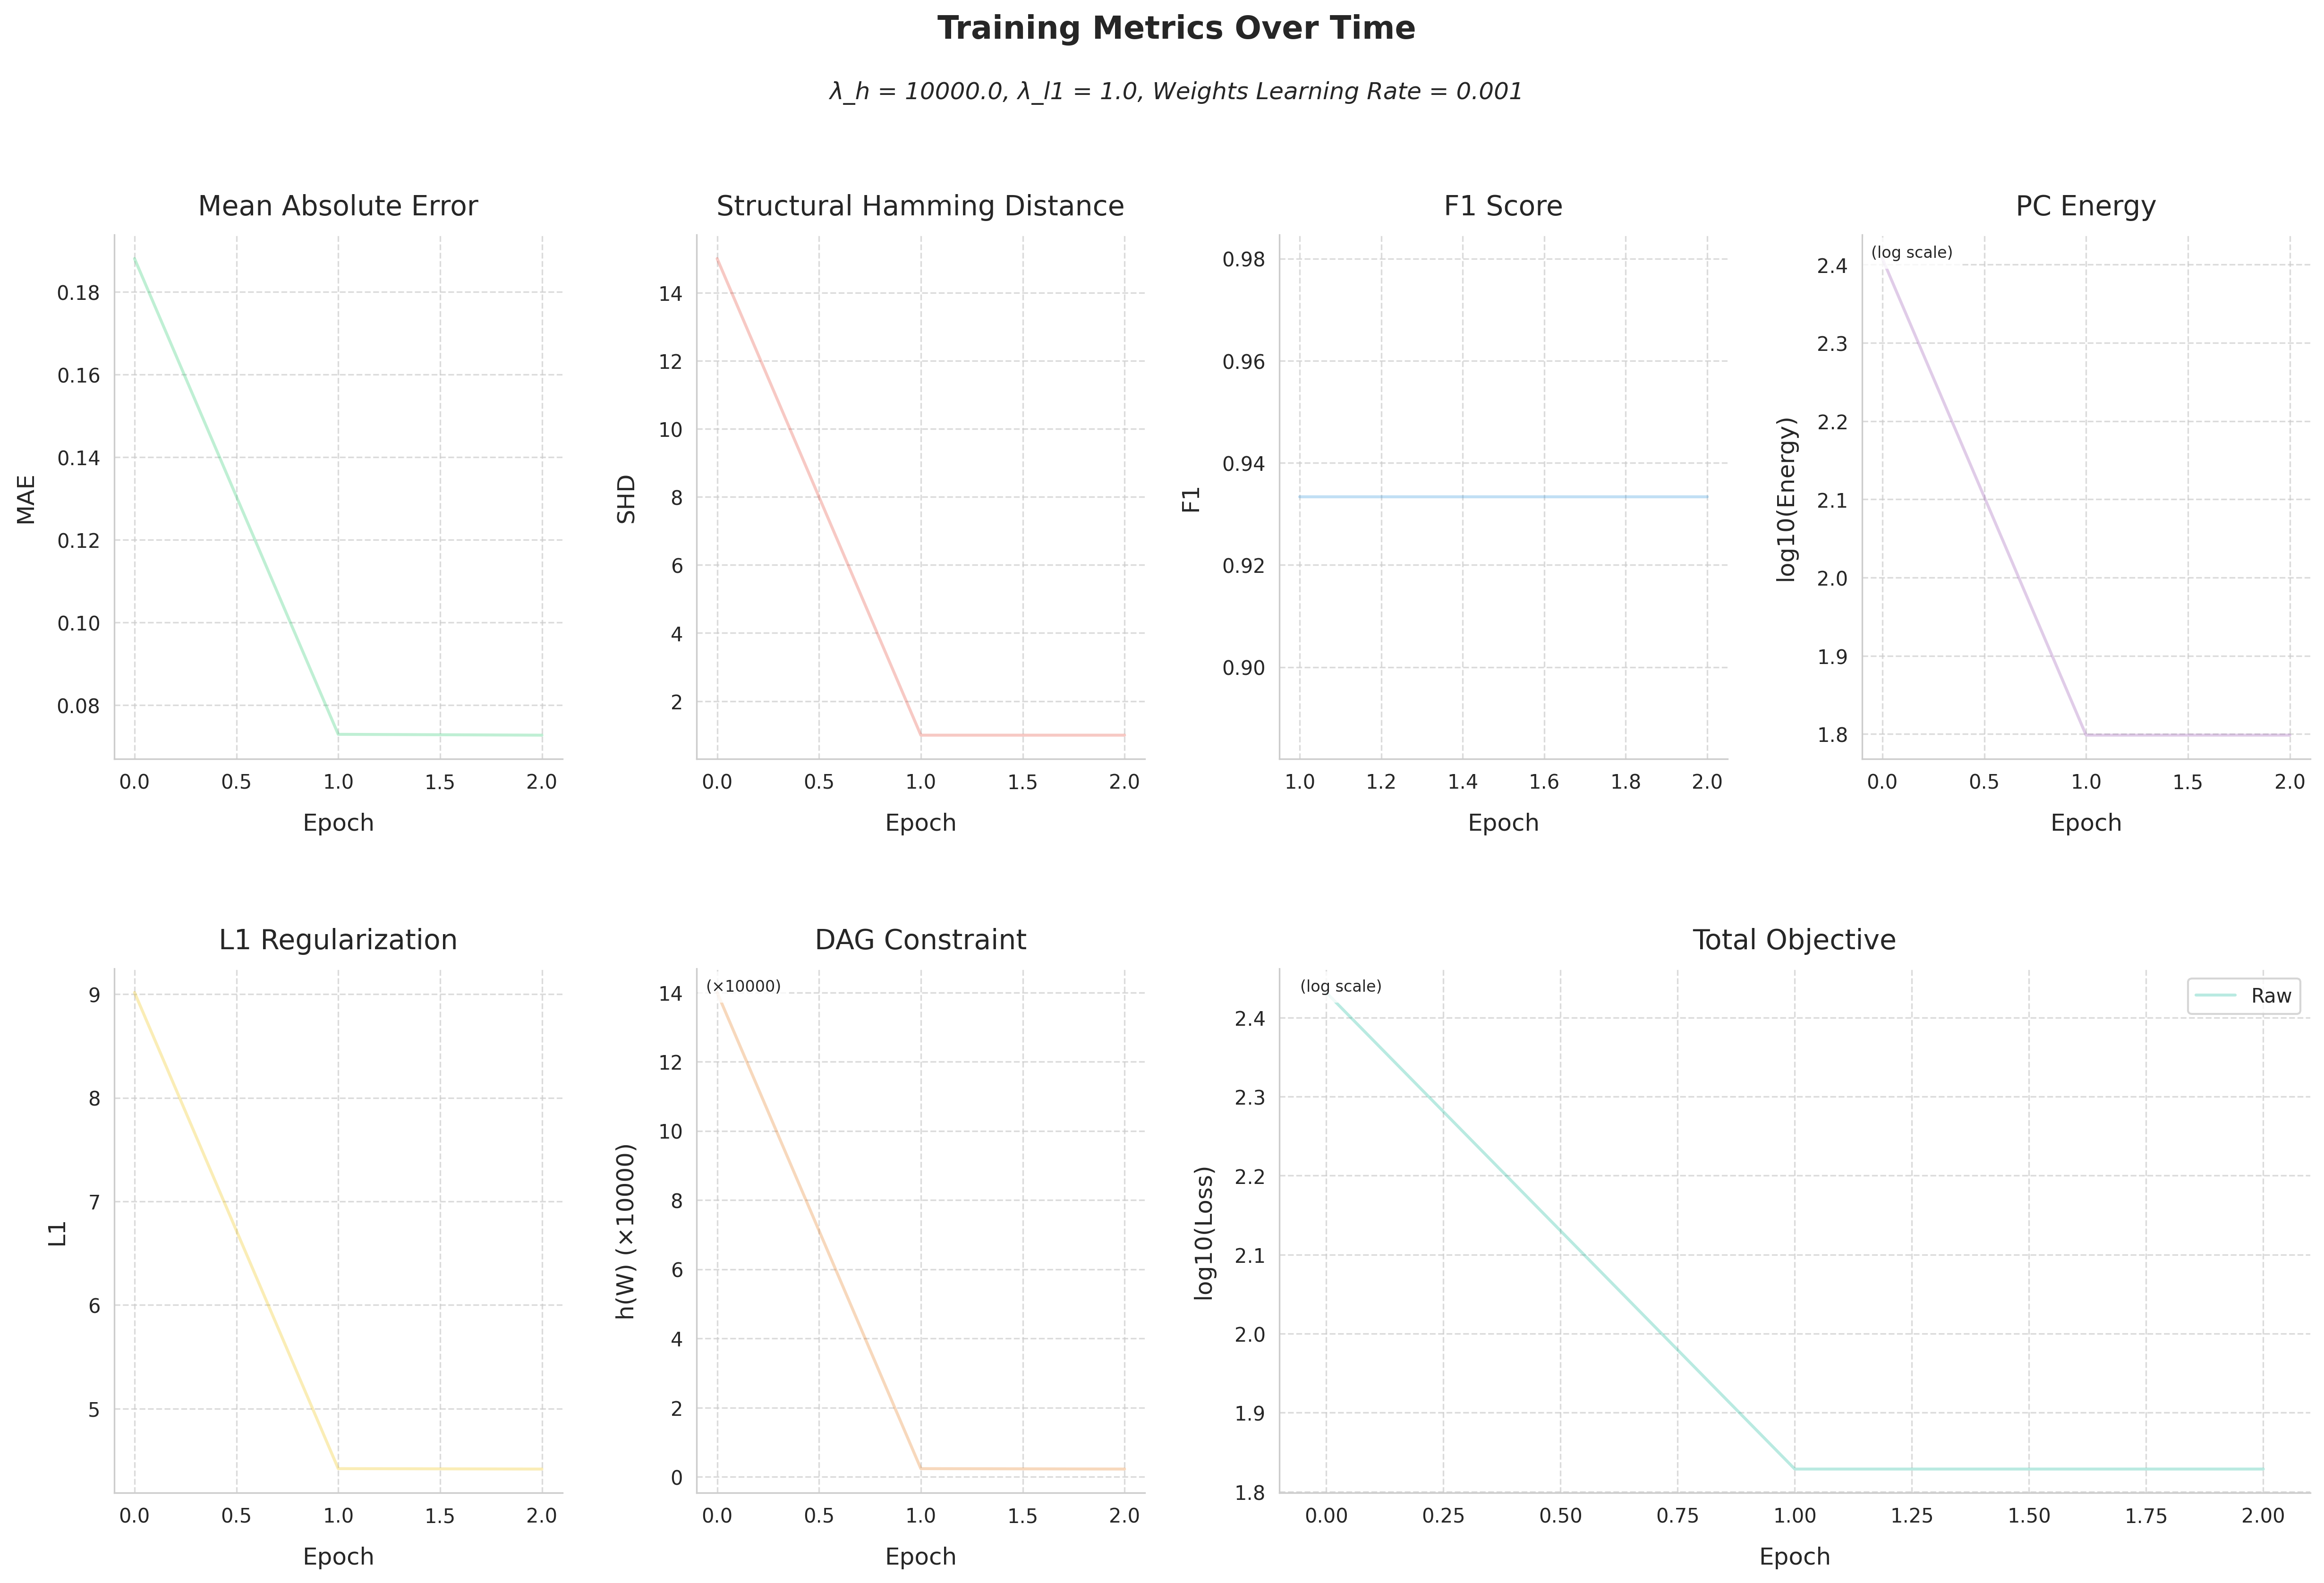

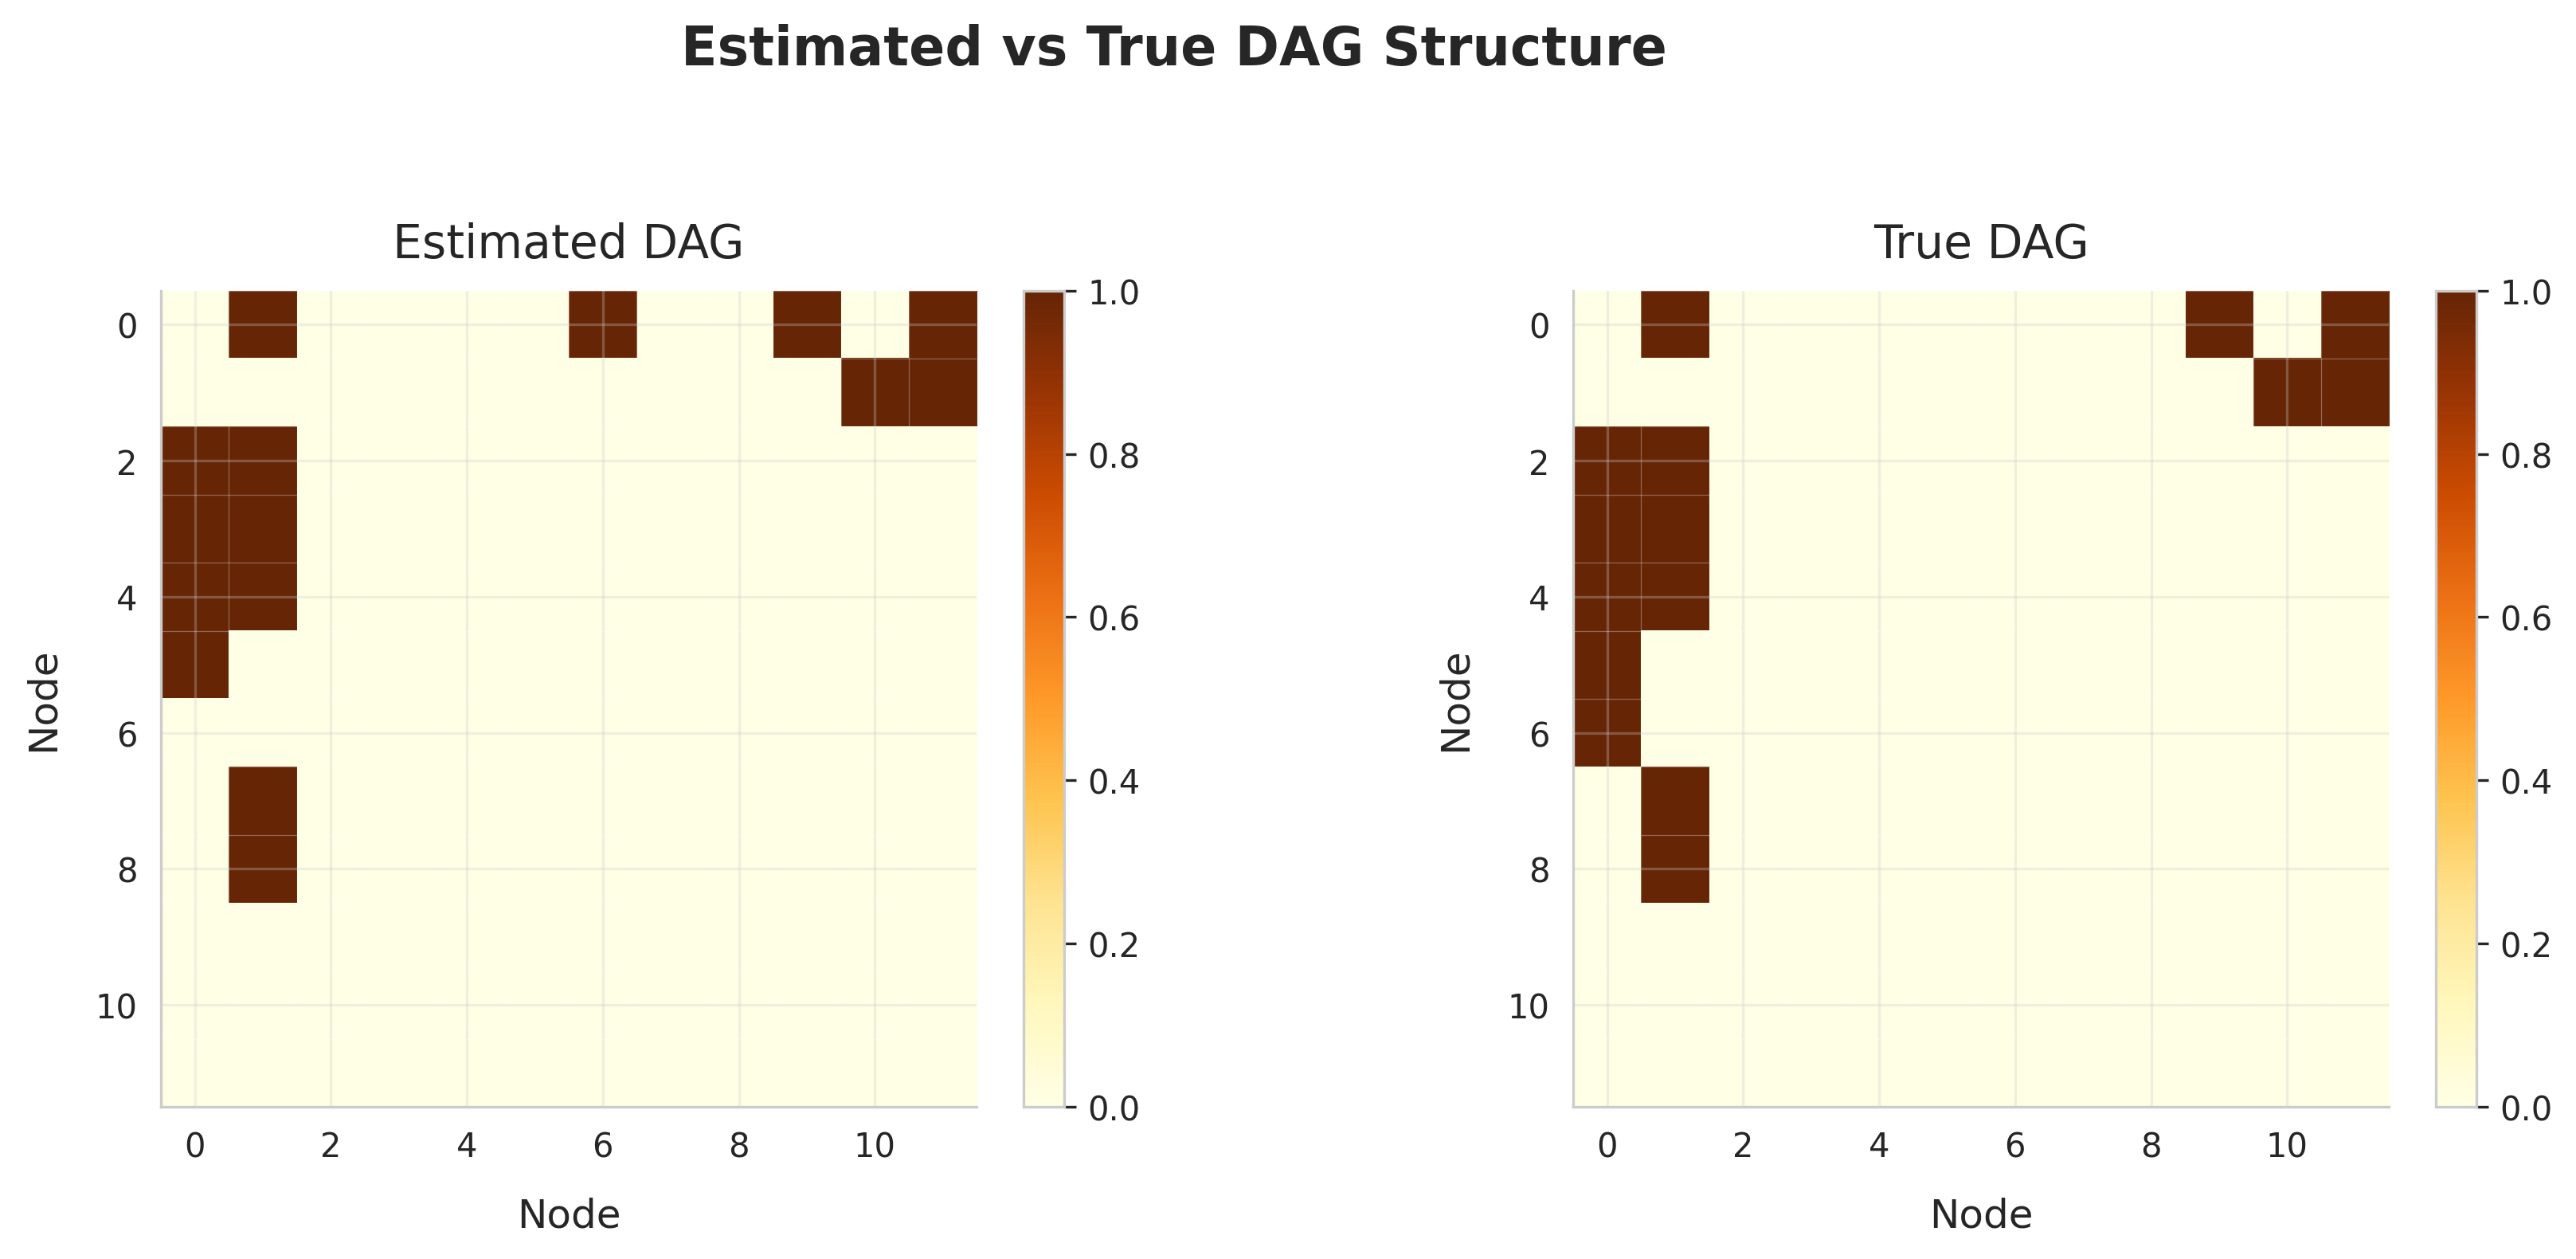

Is the estimated binary adjacency matrix a DAG? True
The h_reg term for the true weighted adjacency matrix W_true is: -0.0000
The h_reg term for the estimated weighted adjacency matrix W_est is: 0.0000
The first 5 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.      1.9695 -0.0002 -0.0004 -0.0003]
 [ 0.0003  0.     -0.0003  0.0006 -0.0003]
 [-0.5956 -1.748   0.     -0.1265 -0.0247]
 [-0.9358  2.0308 -0.0001  0.     -0.0012]
 [-0.7532 -1.7511 -0.013  -0.1087  0.    ]]


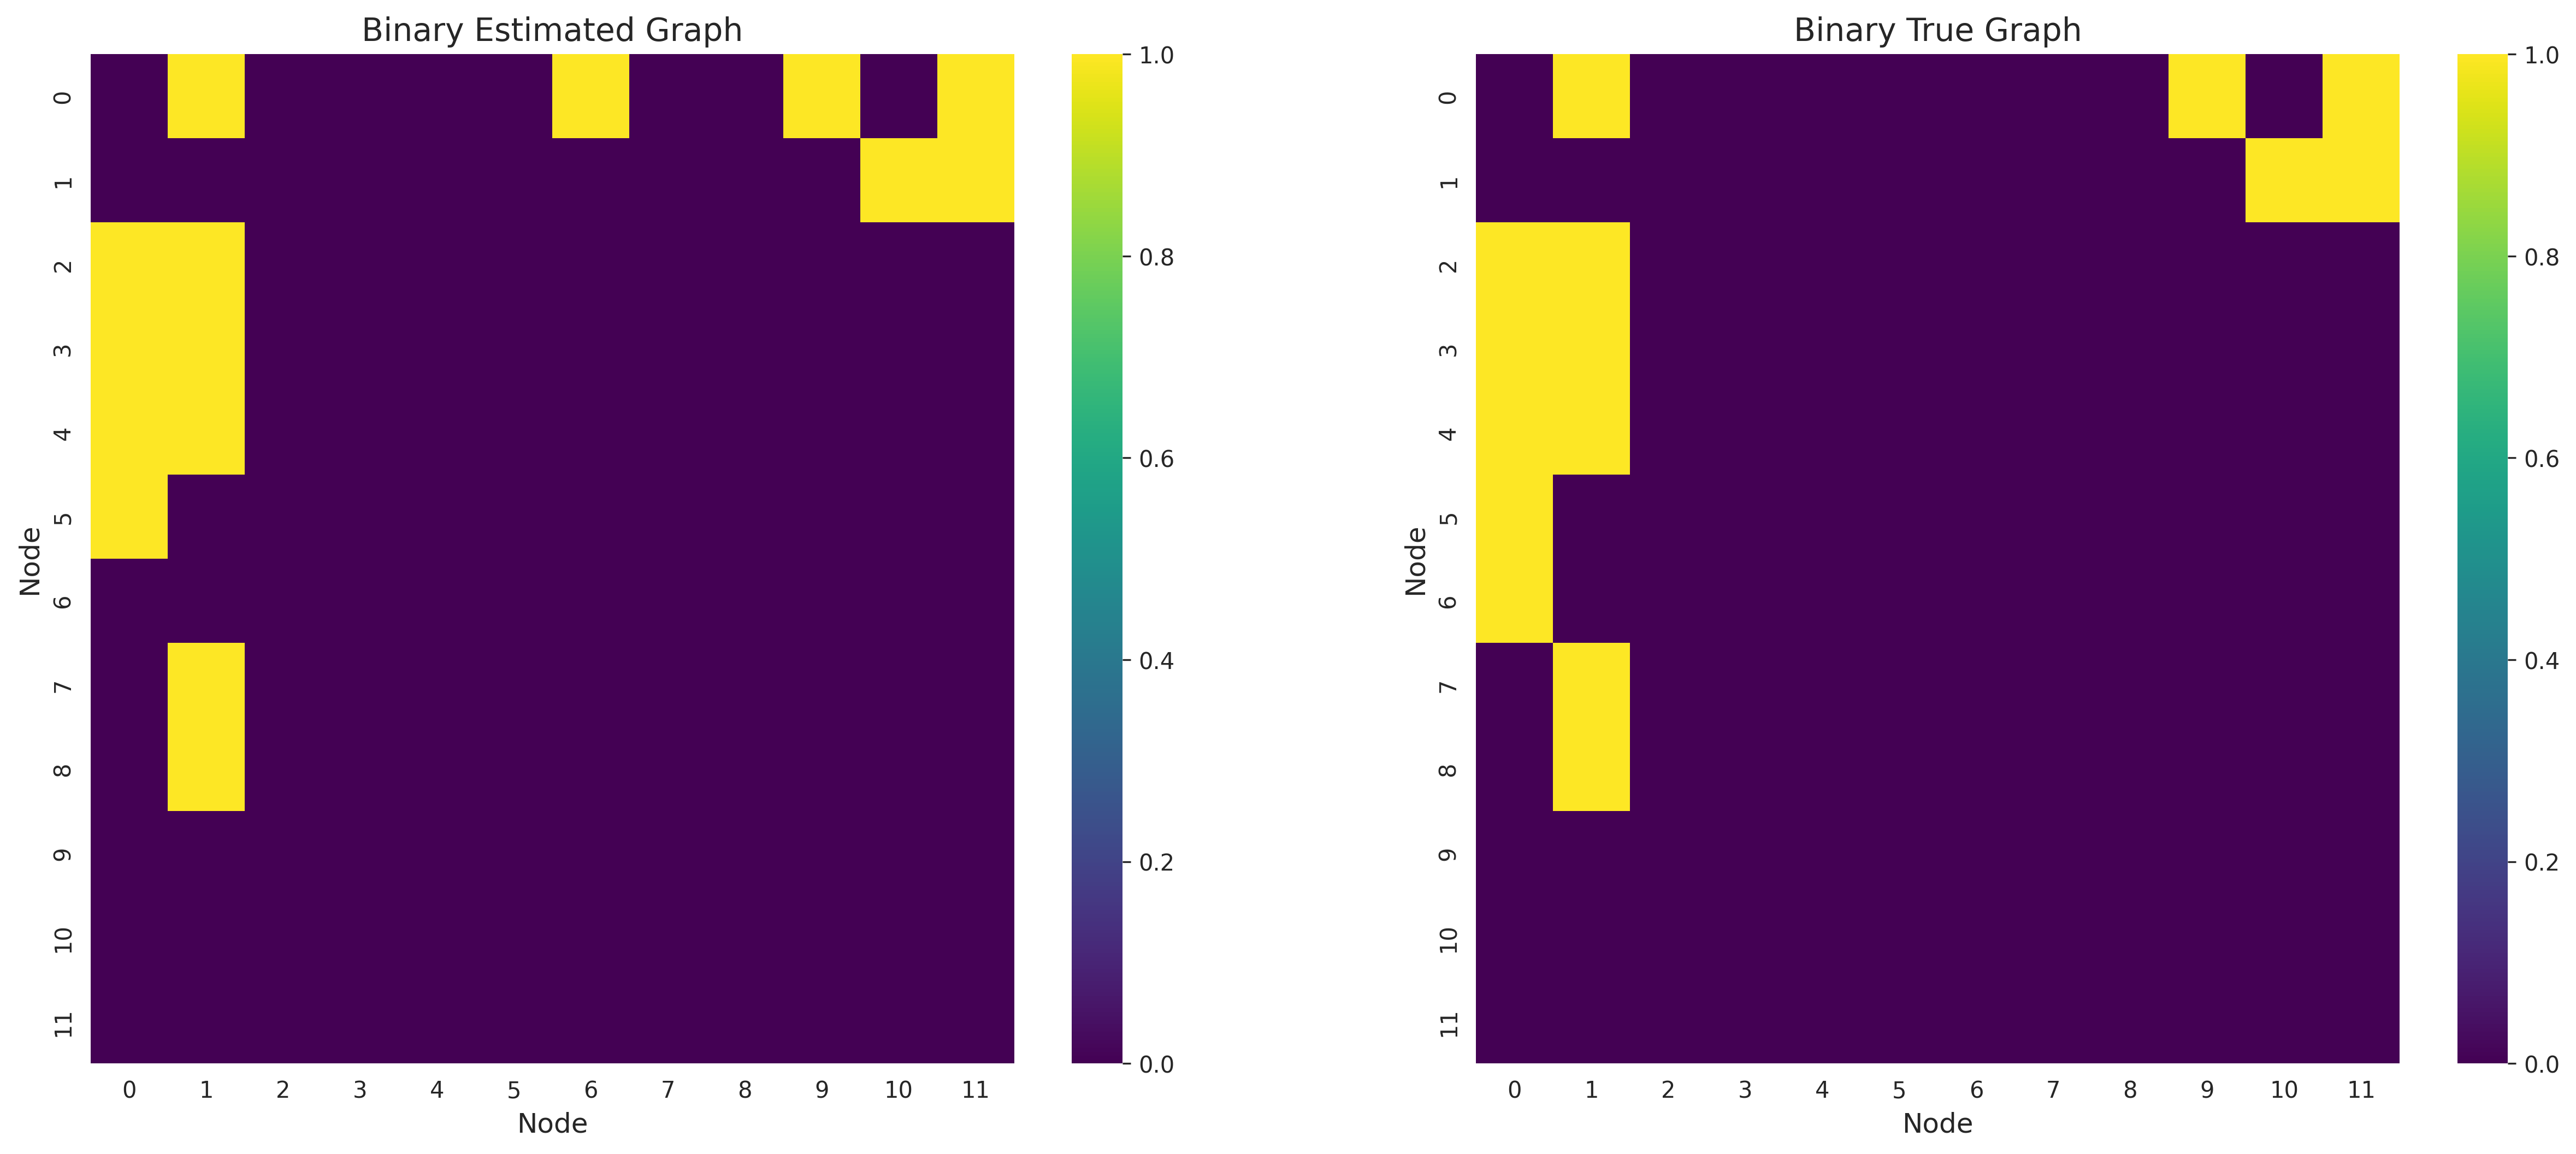

The number of edges in the true graph: 15.0
The number of edges in the estimated graph: 15


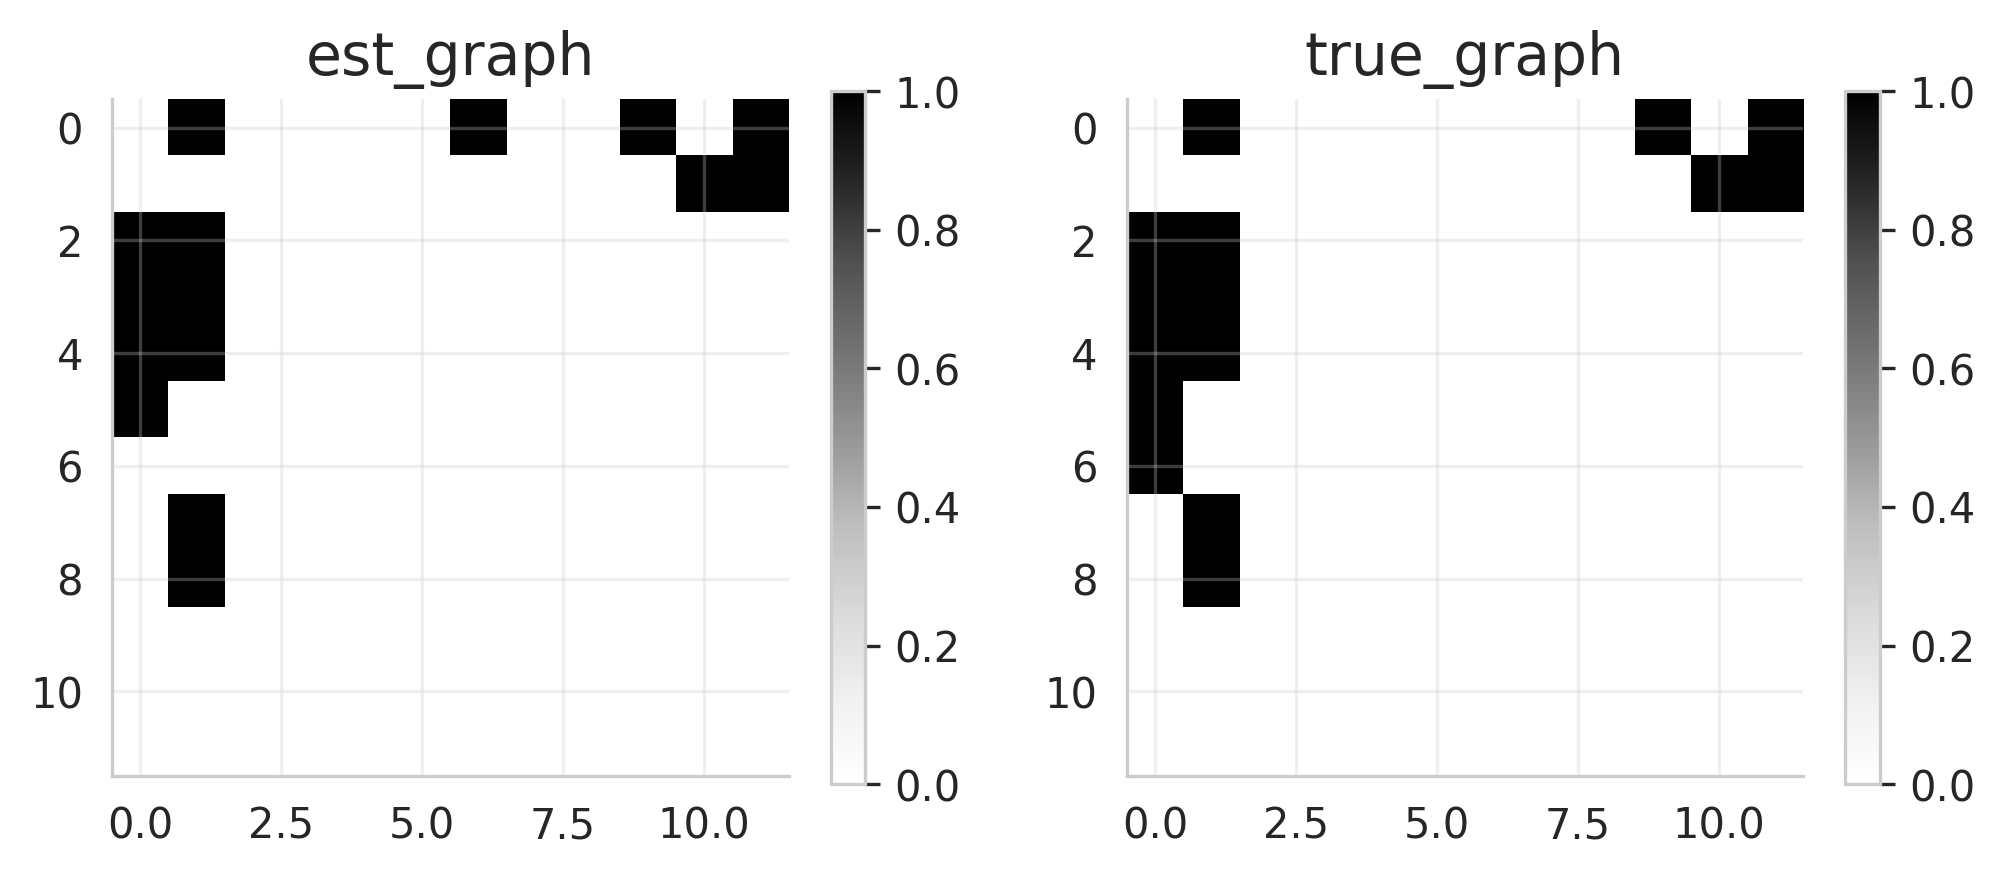

{'fdr': 0.0667, 'tpr': 0.9333, 'fpr': 0.0196, 'shd': 1, 'nnz': 15, 'precision': 0.9333, 'recall': 0.9333, 'F1': 0.9333, 'gscore': 0.8667}


In [9]:
# Define experiment name
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"

# Create subdirectory in linear folder with the name stored in exp_name
save_path = os.path.join('plots/linear_mixed_disc_x0', exp_name)
os.makedirs(save_path, exist_ok=True)

# Reset to default style and set seaborn style
plt.style.use('default')
sns.set_style("whitegrid")

# Update matplotlib parameters
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Create a figure and subplots using GridSpec
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

# Adjust layout to make more room for title and subtitle
plt.subplots_adjust(top=0.85, hspace=0.4, wspace=0.3)

# Create axes
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax03 = fig.add_subplot(gs[0, 3])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[1, 2:])
# ax12 spans two columns

axes = [ax00, ax01, ax02, ax03, ax10, ax11, ax12]

# Plot configurations
plot_configs = [
    {'metric': MAEs, 'title': 'Mean Absolute Error', 'ylabel': 'MAE', 'color': '#2ecc71', 'ax': ax00},
    {'metric': SHDs, 'title': 'Structural Hamming Distance', 'ylabel': 'SHD', 'color': '#e74c3c', 'ax': ax01},
    {'metric': F1s, 'title': 'F1 Score', 'ylabel': 'F1', 'color': '#3498db', 'ax': ax02},
    {'metric': pc_energies, 'title': 'PC Energy', 'ylabel': 'Energy', 'color': '#9b59b6', 'ax': ax03},
    {'metric': l1_regs, 'title': 'L1 Regularization', 'ylabel': 'L1', 'color': '#f1c40f', 'ax': ax10},
    {'metric': h_regs, 'title': 'DAG Constraint', 'ylabel': 'h(W)', 'color': '#e67e22', 'ax': ax11},
    {'metric': objs, 'title': 'Total Objective', 'ylabel': 'Loss', 'color': '#1abc9c', 'ax': ax12}
]

# Create all subplots
for config in plot_configs:
    ax = config['ax']
    
    # Plot data with rolling average
    epochs = range(len(config['metric']))
    
    # Determine if we should use log scale and/or scaling factor
    use_log_scale = config['title'] in ['PC Energy', 'Total Objective']
    scale_factor = 1e4 if config['title'] == 'DAG Constraint' else 1
    
    # Apply scaling and/or log transform to the metric
    metric_values = np.array(config['metric'])
    if use_log_scale:
        # Add small constant to avoid log(0)
        metric_values = np.log10(np.abs(metric_values) + 1e-10)
    metric_values = metric_values * scale_factor
    
    # Plot raw data
    raw_line = ax.plot(epochs, metric_values, 
                      alpha=0.3, 
                      color=config['color'], 
                      label='Raw')
    
    # Calculate and plot rolling average
    window_size = 50
    if len(metric_values) > window_size:
        rolling_mean = np.convolve(metric_values, 
                                 np.ones(window_size)/window_size, 
                                 mode='valid')
        ax.plot(range(window_size-1, len(metric_values)), 
                rolling_mean, 
                color=config['color'], 
                linewidth=2, 
                label='Moving Average')
    
    # Customize each subplot
    ax.set_title(config['title'], pad=10)
    ax.set_xlabel('Epoch', labelpad=10)
    
    # Adjust ylabel based on transformations
    ylabel = config['ylabel']
    if use_log_scale:
        ylabel = f'log10({ylabel})'
    if scale_factor != 1:
        ylabel = f'{ylabel} (×{int(scale_factor)})'
    ax.set_ylabel(ylabel, labelpad=10)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend if it's the total objective plot
    if config['title'] == 'Total Objective':
        ax.legend(loc='upper right')
        
    # Add note about scaling if applicable
    if use_log_scale or scale_factor != 1:
        transform_text = []
        if use_log_scale:
            transform_text.append('log scale')
        if scale_factor != 1:
            transform_text.append(f'×{int(scale_factor)}')
        ax.text(0.02, 0.98, f"({', '.join(transform_text)})", 
                transform=ax.transAxes, 
                fontsize=8, 
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add overall title and subtitle with adjusted positions
fig.suptitle('Training Metrics Over Time', 
            fontsize=16, 
            weight='bold', 
            y=0.98)

subtitle = f'λ_h = {lam_h}, λ_l1 = {lam_l1}, Weights Learning Rate = {w_learning_rate}'
fig.text(0.5, 0.93, 
         subtitle, 
         horizontalalignment='center',
         fontsize=12,
         style='italic')

# Save and show the figure as a .pdf file at the specified location
plt.savefig(os.path.join(save_path, 'training_metrics.pdf'), 
            bbox_inches='tight', 
            dpi=300)
plt.show()

# Create a separate figure for the adjacency matrices comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Use a better colormap - options:
# 'YlOrBr' - Yellow-Orange-Brown (good for sparse matrices)
# 'viridis' - Perceptually uniform, colorblind-friendly
# 'Greys' - Black and white, professional
# 'YlGnBu' - Yellow-Green-Blue, professional
cmap = 'YlOrBr'  # Choose one of the above

# Plot estimated adjacency matrix (now on the left)
im1 = ax1.imshow(compute_binary_adjacency(W), cmap=cmap, interpolation='nearest')
ax1.set_title('Estimated DAG', pad=10)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlabel('Node', labelpad=10)
ax1.set_ylabel('Node', labelpad=10)

# Plot true adjacency matrix (now on the right)
im2 = ax2.imshow(B_true, cmap=cmap, interpolation='nearest')
ax2.set_title('True DAG', pad=10)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_xlabel('Node', labelpad=10)
ax2.set_ylabel('Node', labelpad=10)

# Add overall title
fig.suptitle('Estimated vs True DAG Structure', 
             fontsize=16, 
             weight='bold', 
             y=1.05)

# Add grid lines to better separate the nodes
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

# Improve layout
plt.tight_layout()

# Save the comparison plot as a .pdf file at the specified location
plt.savefig(os.path.join(save_path, 'dag_comparison.pdf'), 
            bbox_inches='tight', 
            dpi=300,
            facecolor='white',
            edgecolor='none')
plt.show()

# %%
# Now use a threshold of 0.3 to binarize the weighted adjacency matrix W
W_est = np.array(model.get_W())
B_est = compute_binary_adjacency(W_est, threshold=0.3)

# %%
# Check if B_est is indeed a DAG
def is_dag(adjacency_matrix):
    """
    Check if a given adjacency matrix represents a Directed Acyclic Graph (DAG).
    
    Parameters:
        adjacency_matrix (numpy.ndarray): A square matrix representing the adjacency of a directed graph.
        
    Returns:
        bool: True if the graph is a DAG, False otherwise.
    """
    # Create a directed graph from the adjacency matrix
    graph = nx.DiGraph(adjacency_matrix)
    
    # Check if the graph is a DAG
    return nx.is_directed_acyclic_graph(graph)

# Check if the estimated binary adjacency matrix B_est is a DAG
is_dag_B_est = is_dag(B_est)
print(f"Is the estimated binary adjacency matrix a DAG? {is_dag_B_est}")


# Compute the h_reg term for the true weighted adjacency matrix W_true
h_reg_true = compute_h_reg(W_true)
print(f"The h_reg term for the true weighted adjacency matrix W_true is: {h_reg_true:.4f}")

# Compute the h_reg term for the estimated weighted adjacency matrix W_est
h_reg_est = compute_h_reg(W_est)
print(f"The h_reg term for the estimated weighted adjacency matrix W_est is: {h_reg_est:.4f}")

# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 5 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:5, :5]))

# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(true_matrix=B_true, est_matrix=B_est, save_path=os.path.join(save_path, 'adjacency_matrices.png'))

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the true graph: {np.sum(B_true)}")
print(f"The number of edges in the estimated graph: {np.sum(B_est)}")

# %%
# plot est_dag and true_dag
GraphDAG(B_est, B_true, save_name=os.path.join(save_path, 'est_dag_true_dag.png'))
# calculate accuracy
met_pcx = MetricsDAG(B_est, B_true)
print(met_pcx.metrics)

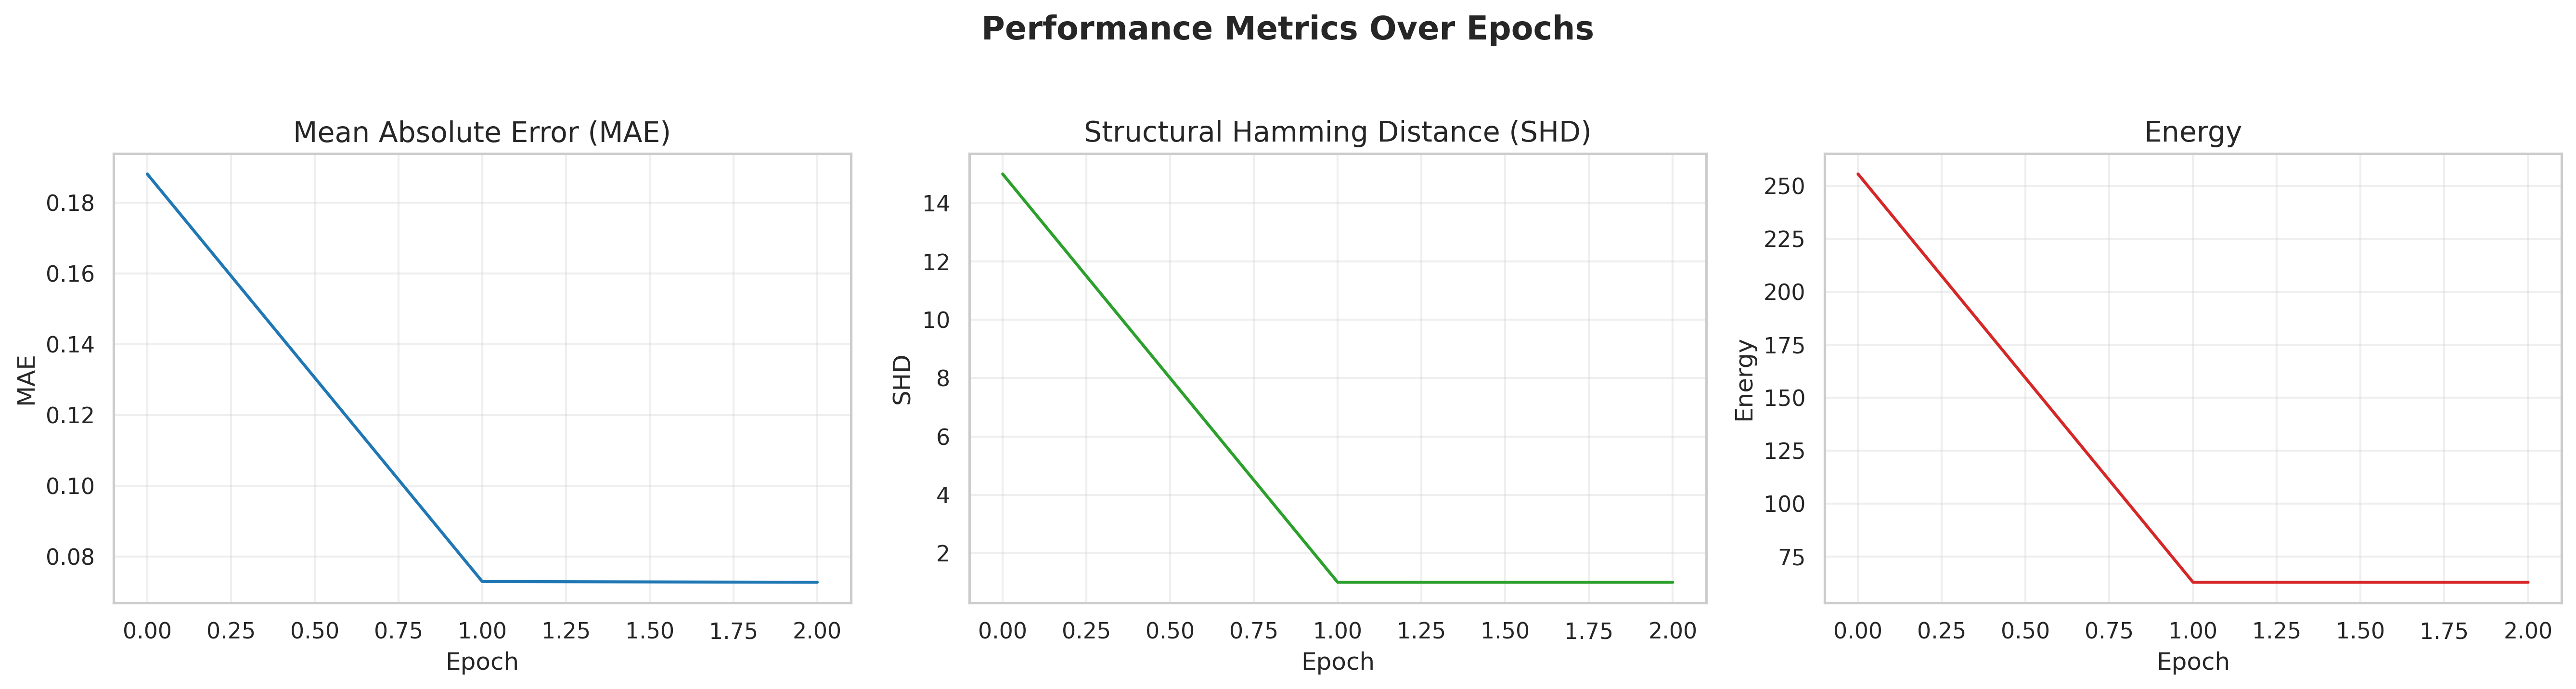

In [10]:
# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("tab10")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjusting layout to 1 row and 3 columns
fig.suptitle('Performance Metrics Over Epochs', fontsize=16, weight='bold')

# Plot the MAE
sns.lineplot(x=range(len(MAEs)), y=MAEs, ax=axs[0], color=palette[0])
axs[0].set_title("Mean Absolute Error (MAE)", fontsize=14)
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].set_ylabel("MAE", fontsize=12)
axs[0].grid(True)

# Plot the SHD
sns.lineplot(x=range(len(SHDs)), y=SHDs, ax=axs[1], color=palette[2])
axs[1].set_title("Structural Hamming Distance (SHD)", fontsize=14)
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].set_ylabel("SHD", fontsize=12)
axs[1].grid(True)

# Plot the Energy
sns.lineplot(x=range(len(pc_energies)), y=pc_energies, ax=axs[2], color=palette[3])
axs[2].set_title("Energy", fontsize=14)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_ylabel("Energy", fontsize=12)
axs[2].grid(True)

# Improve layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

In [11]:
# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 4 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:11, :11]))

The first 4 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.      1.9695 -0.0002 -0.0004 -0.0003 -0.0005 -1.5293 -0.0002 -0.0005
   1.4925  0.0005]
 [ 0.0003  0.     -0.0003  0.0006 -0.0003  0.0002  0.0013 -0.0006 -0.0017
   0.0003  1.1986]
 [-0.5956 -1.748   0.     -0.1265 -0.0247 -0.002  -0.0006 -0.2417 -0.0625
   0.1649  0.0767]
 [-0.9358  2.0308 -0.0001  0.     -0.0012  0.0008 -0.2984  0.0005 -0.0137
   0.0152  0.0395]
 [-0.7532 -1.7511 -0.013  -0.1087  0.     -0.1738  0.0002 -0.0008 -0.1076
   0.1886  0.1093]
 [-0.721   0.1313 -0.1434 -0.0811 -0.0008  0.     -0.0559 -0.0398 -0.1022
   0.1629  0.1246]
 [-0.0002  0.0508  0.0001 -0.0001  0.      0.0001  0.      0.0003 -0.0011
   0.0058  0.0507]
 [-0.0005 -0.9806 -0.0002 -0.1048 -0.1173 -0.0049  0.1166  0.     -0.0088
   0.098   0.0533]
 [-0.0002 -1.18    0.     -0.0007 -0.0008 -0.002   0.0419  0.0012  0.
   0.0006  0.0005]
 [ 0.0001  0.0887 -0.0002 -0.0002 -0.0002 -0.0004  0.1364 -0.0018 -0.1024
   0.      0.08

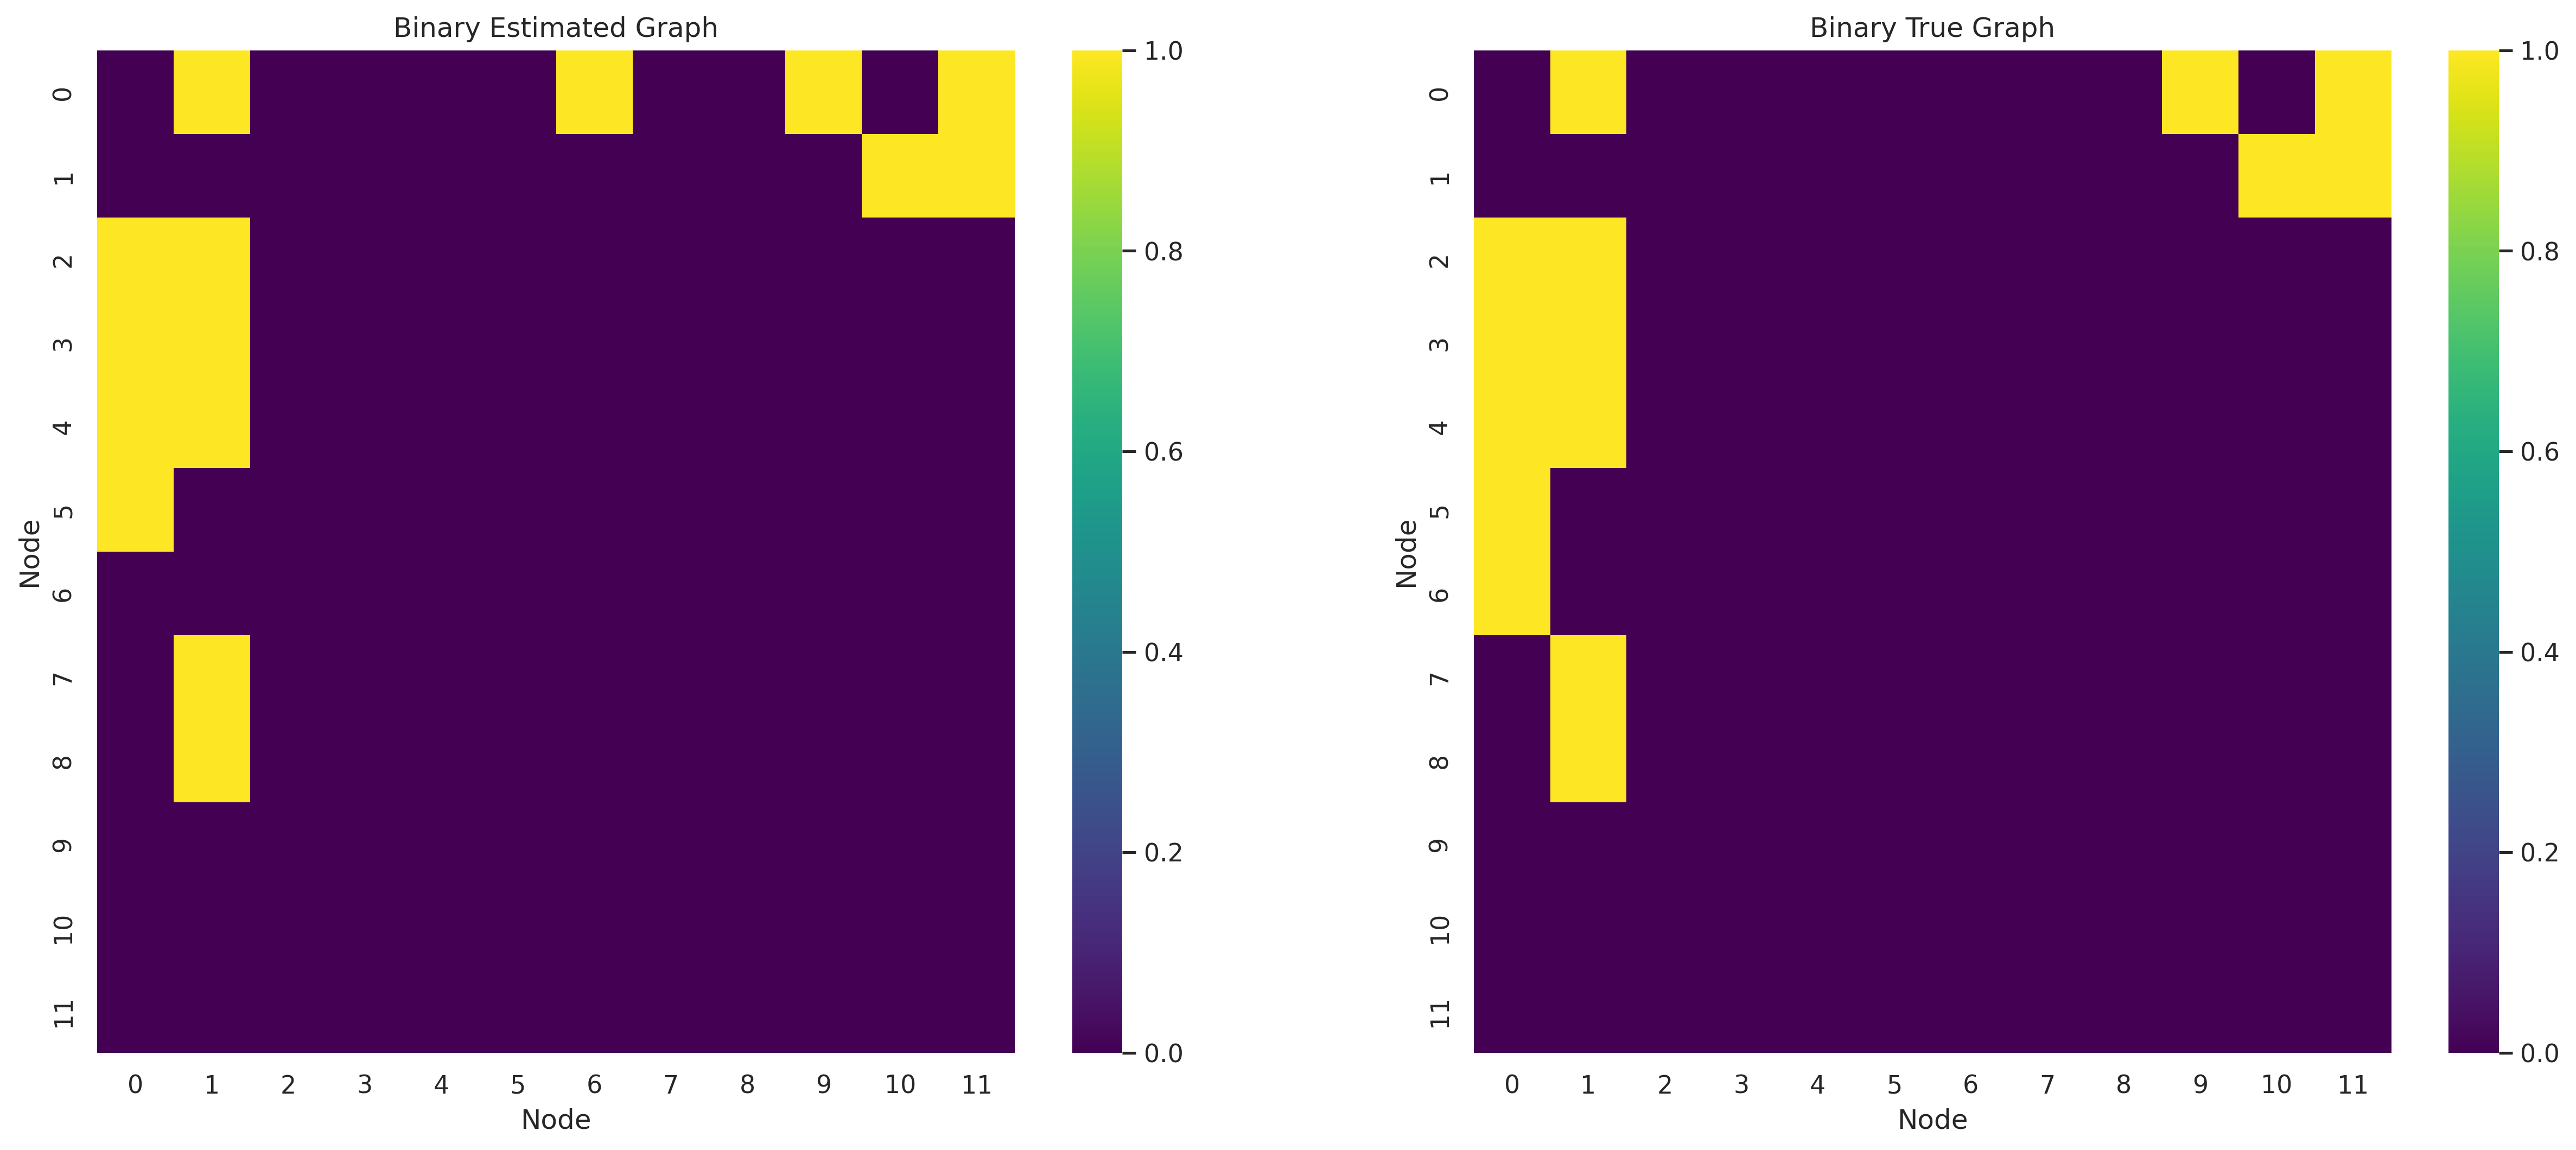

The number of edges in the true graph: 15.0
The number of edges in the estimated graph: 15


In [12]:
# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(B_true, B_est)

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the true graph: {np.sum(B_true)}")
print(f"The number of edges in the estimated graph: {np.sum(B_est)}")

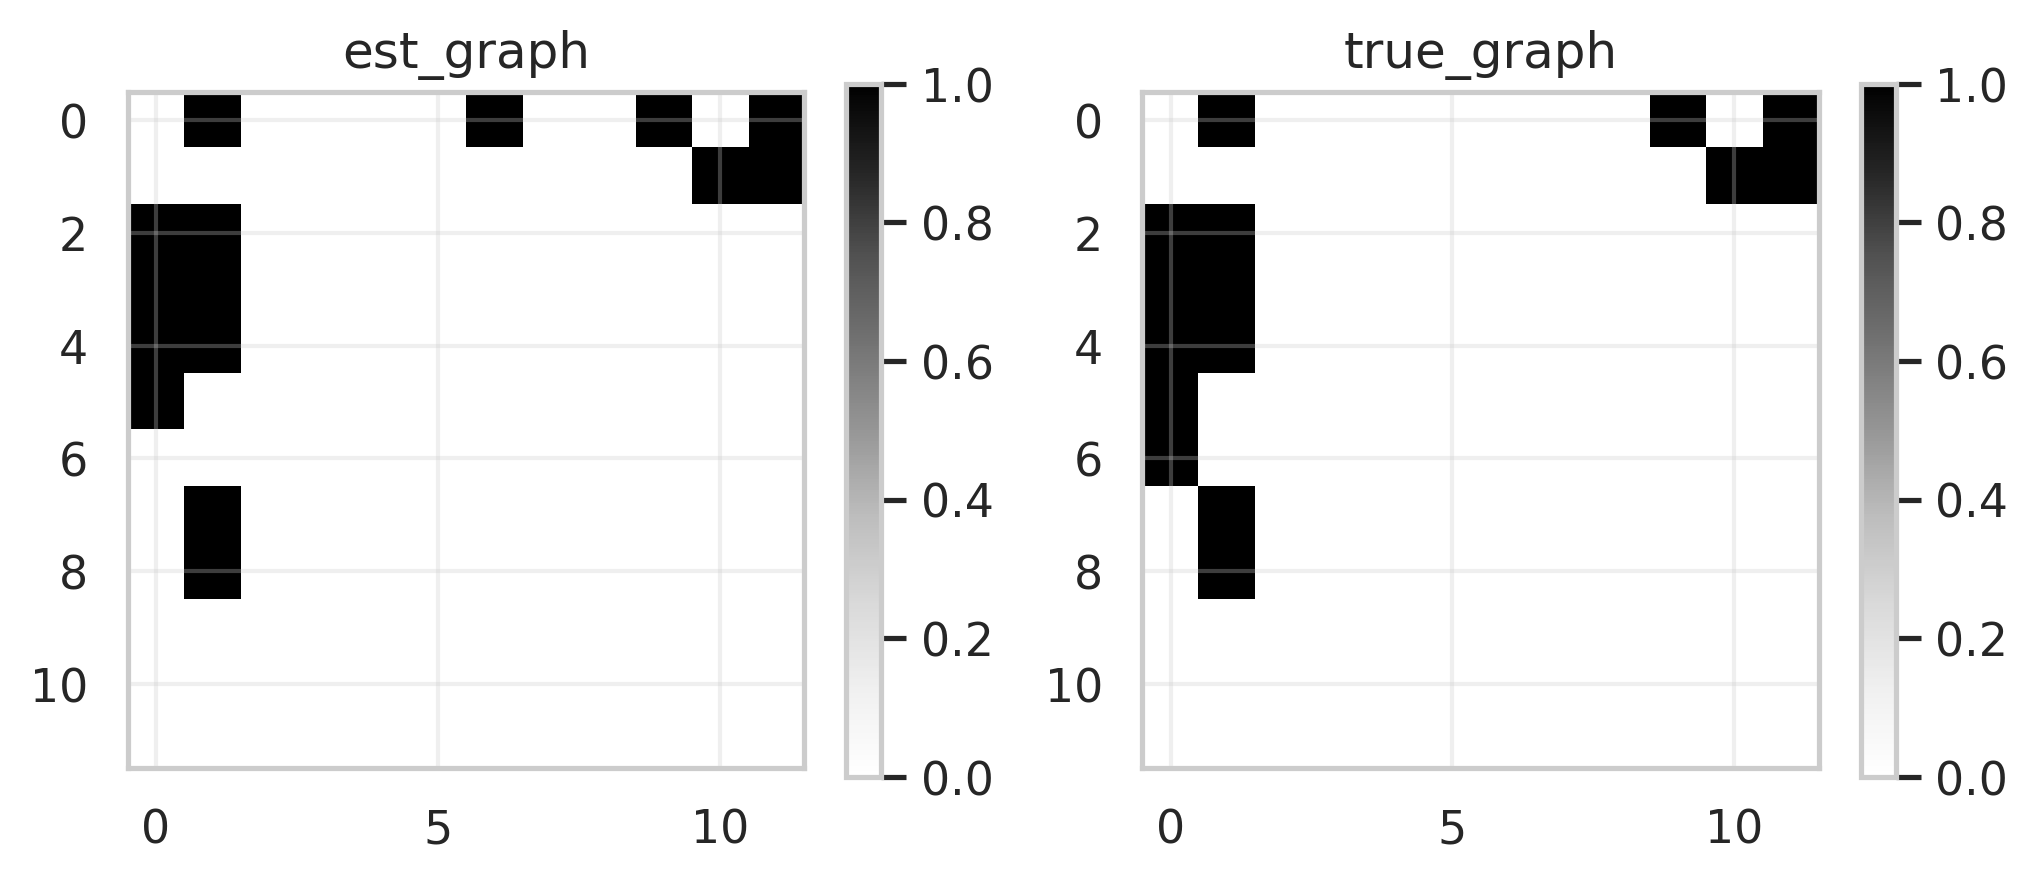

{'fdr': 0.0667, 'tpr': 0.9333, 'fpr': 0.0196, 'shd': 1, 'nnz': 15, 'precision': 0.9333, 'recall': 0.9333, 'F1': 0.9333, 'gscore': 0.8667}
bs_128_lrw_0.001_lrh_0.0001_lamh_10000.0_laml1_1.0_epochs_1000


In [13]:
# plot est_dag and true_dag
GraphDAG(B_est, B_true)
# calculate accuracy
met_pcax = MetricsDAG(B_est, B_true)
print(met_pcax.metrics)

# print experiment name
print(exp_name)

2025-02-18 13:54:51,316 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:229] - INFO: [start]: n=4000, d=12, iter_=100, h_=1e-05, rho_=1e+16
2025-02-18 13:55:08,454 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:247] - INFO: [iter 0] h=8.175e-01, loss=81294782804526321404102330622387563453414261929220767744.000, rho=1.0e+00
2025-02-18 13:55:25,544 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:247] - INFO: [iter 1] h=3.902e-01, loss=465.523, rho=1.0e+00
2025-02-18 13:55:43,243 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:247] - INFO: [iter 1] h=3.195e-01, loss=468.530, rho=1.0e+01
2025-02-18 13:55:53,364 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packa

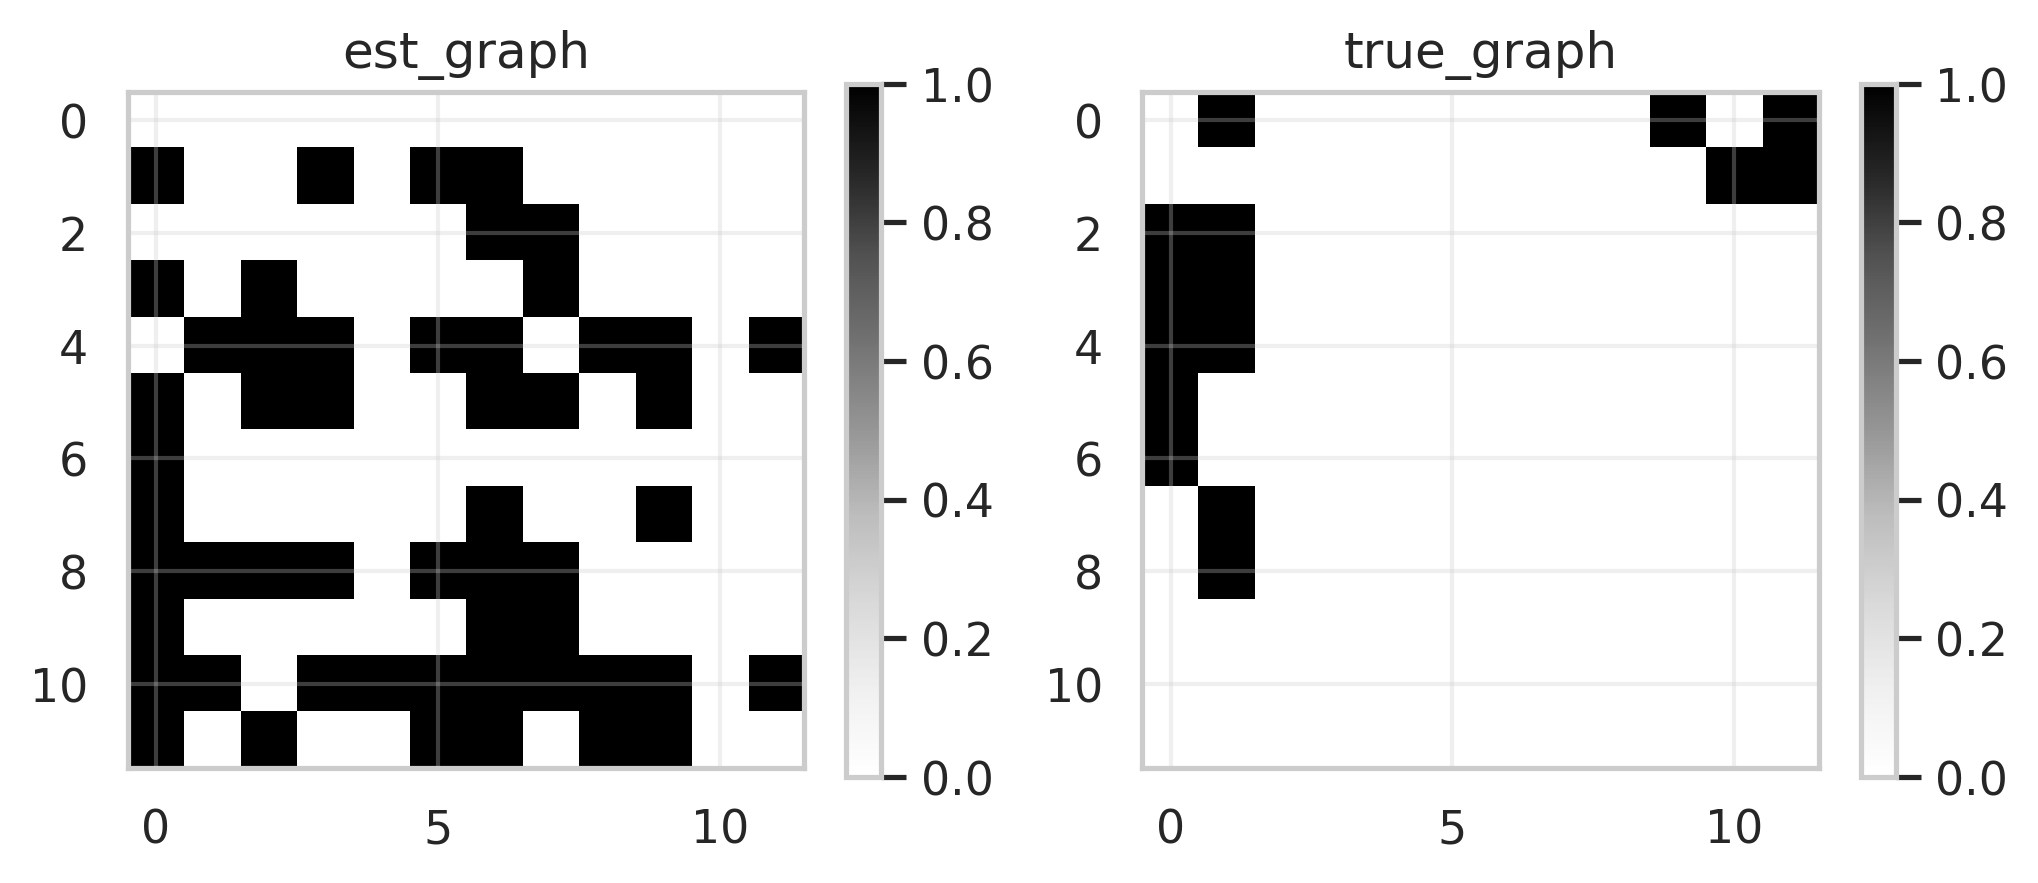

{'fdr': 0.9038, 'tpr': 0.3333, 'fpr': 0.9216, 'shd': 52, 'nnz': 52, 'precision': 0.0943, 'recall': 0.3333, 'F1': 0.1471, 'gscore': 0.0}


In [ ]:
# notears learn
#nt = Notears(lambda1=0.1, h_tol=1e-5, max_iter=100, loss_type='l2', seed=seed) # takes 8 seconds, final loss @ 4.1
nt = Notears(lambda1=1e0, h_tol=1e-5, max_iter=100, loss_type='laplace', seed=seed) # takes 16 seconds, final loss @ 8.2
#nt = Notears(lambda1=0.1, h_tol=1e-3, max_iter=100, loss_type='logistic', seed=seed) # takes over 5 minutes, final loss @ 245
#nt = Notears(lambda1=0.1, h_tol=1se-3, max_iter=100, loss_type='poisson', seed=seed)
nt.learn(X)

# plot est_dag and true_dag
W_est_nt = np.array(nt.weight_causal_matrix)
B_est_nt = np.array(nt.causal_matrix)
GraphDAG(B_est_nt, B_true)

# calculate accuracy
met_nt = MetricsDAG(B_est_nt, B_true)
print(met_nt.metrics)

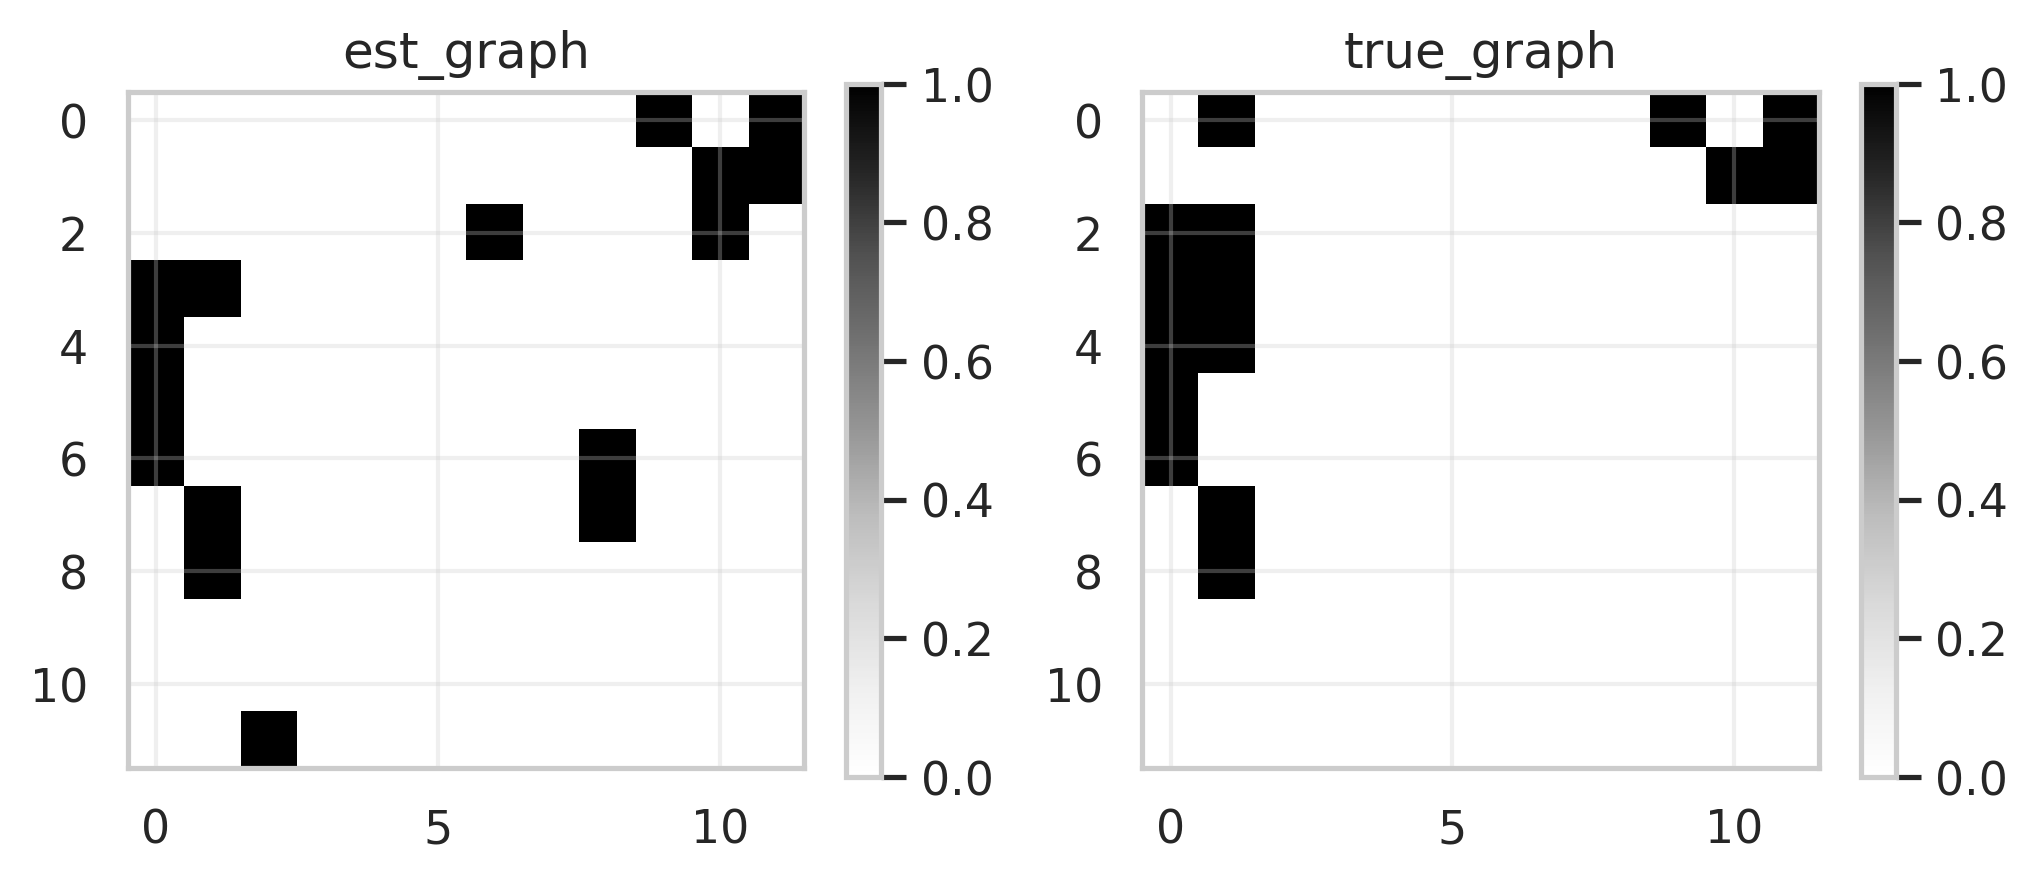

{'fdr': 0.3125, 'tpr': 0.7333, 'fpr': 0.098, 'shd': 9, 'nnz': 16, 'precision': 0.6875, 'recall': 0.7333, 'F1': 0.7097, 'gscore': 0.4}


In [15]:
# Peter & Clark (PC)
# A variant of PC-algorithm, one of [`original`, `stable`, `parallel`]
pc = PC(variant='parallel', alpha=0.2, ci_test='fisherz', random_state=seed) # F1 of 75%
#pc = PC(variant='stable', alpha=0.03) # F1 of 66%
#pc = PC(variant='original', alpha=0.03) # F1 of 55%
pc.learn(X)

# plot est_dag and true_dag
B_est_pc = np.array(pc.causal_matrix)
GraphDAG(B_est_pc, B_true)

# calculate accuracy
met_pc = MetricsDAG(B_est_pc, B_true)
print(met_pc.metrics)

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


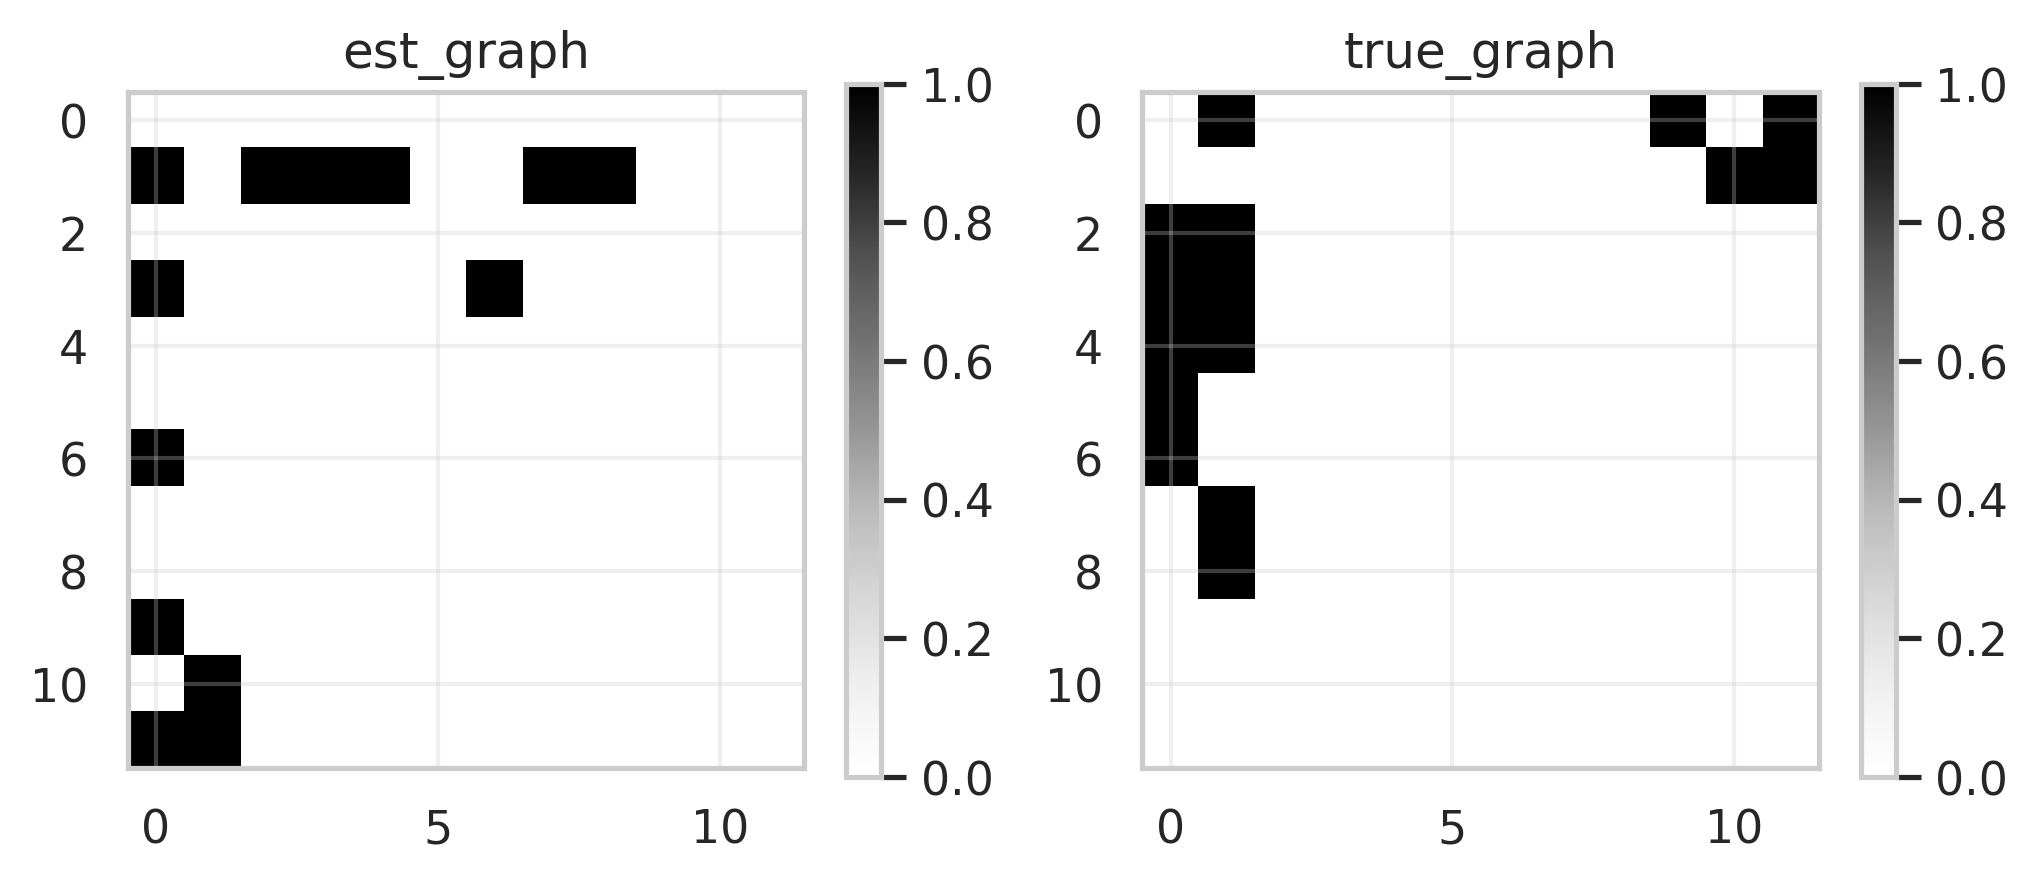

{'fdr': 0.8462, 'tpr': 0.1333, 'fpr': 0.2157, 'shd': 14, 'nnz': 13, 'precision': 0.1538, 'recall': 0.1333, 'F1': 0.1429, 'gscore': 0.0}


In [55]:
# ICALiNGAM (castle based)
# max_iter : int, optional (default=1000)
# g_ICAlingam = ICALiNGAM(max_iter=1000, random_state=seed) # F1 of 71%
# g_ICAlingam.learn(X)
# B_est_icalingam = np.array(g_ICAlingam.causal_matrix)
# W_est_icalingam = np.array(g_ICAlingam.weight_causal_matrix)

# ICALiNGAM (lingam based)
g_ICAlingam = lingam.ICALiNGAM(random_state=seed)
g_ICAlingam.fit(X)
W_est_icalingam = np.array(g_ICAlingam.adjacency_matrix_)
B_est_icalingam = compute_binary_adjacency(W_est_icalingam)

# plot est_dag and true_dag
GraphDAG(B_est_icalingam, B_true)

# calculate accuracy
met_icalingam = MetricsDAG(B_est_icalingam, B_true)
print(met_icalingam.metrics)

W_est (without the 2nd phase) is: 
 [[ 0.     -0.1547  0.      0.      0.      0.     -0.2875  0.      0.
   0.7559  0.      1.6851]
 [ 0.      0.      0.      0.      0.      0.      0.1213  0.      0.
   0.      0.5346 -0.1282]
 [ 0.     -1.8317  0.     -0.1538  0.      0.      0.4416  0.9151 -0.2457
   0.3985 -1.9871 -1.4367]
 [-0.4695  0.7187  0.      0.      0.      0.      0.      0.      0.
  -0.1397  0.4391  0.2157]
 [ 0.     -1.7757  0.2803  0.      0.      0.      0.9658  0.     -0.3347
   0.3977 -1.3647 -1.4296]
 [ 0.     -1.3173 -0.6636  0.28   -0.1172  0.      0.     -1.3749 -0.334
   0.6384 -0.3041 -0.3231]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.    ]
 [-0.3145 -1.7205  0.     -0.3442  0.      0.     -1.6827  0.      0.
   0.6042 -0.8762 -0.4712]
 [ 0.     -0.6454  0.      0.3474  0.      0.     -0.2927  0.      0.
   0.     -0.4301 -0.1555]
 [ 0.      0.8189  0.      0.      0.      0.     -0.4781  0.      0.
   0.     

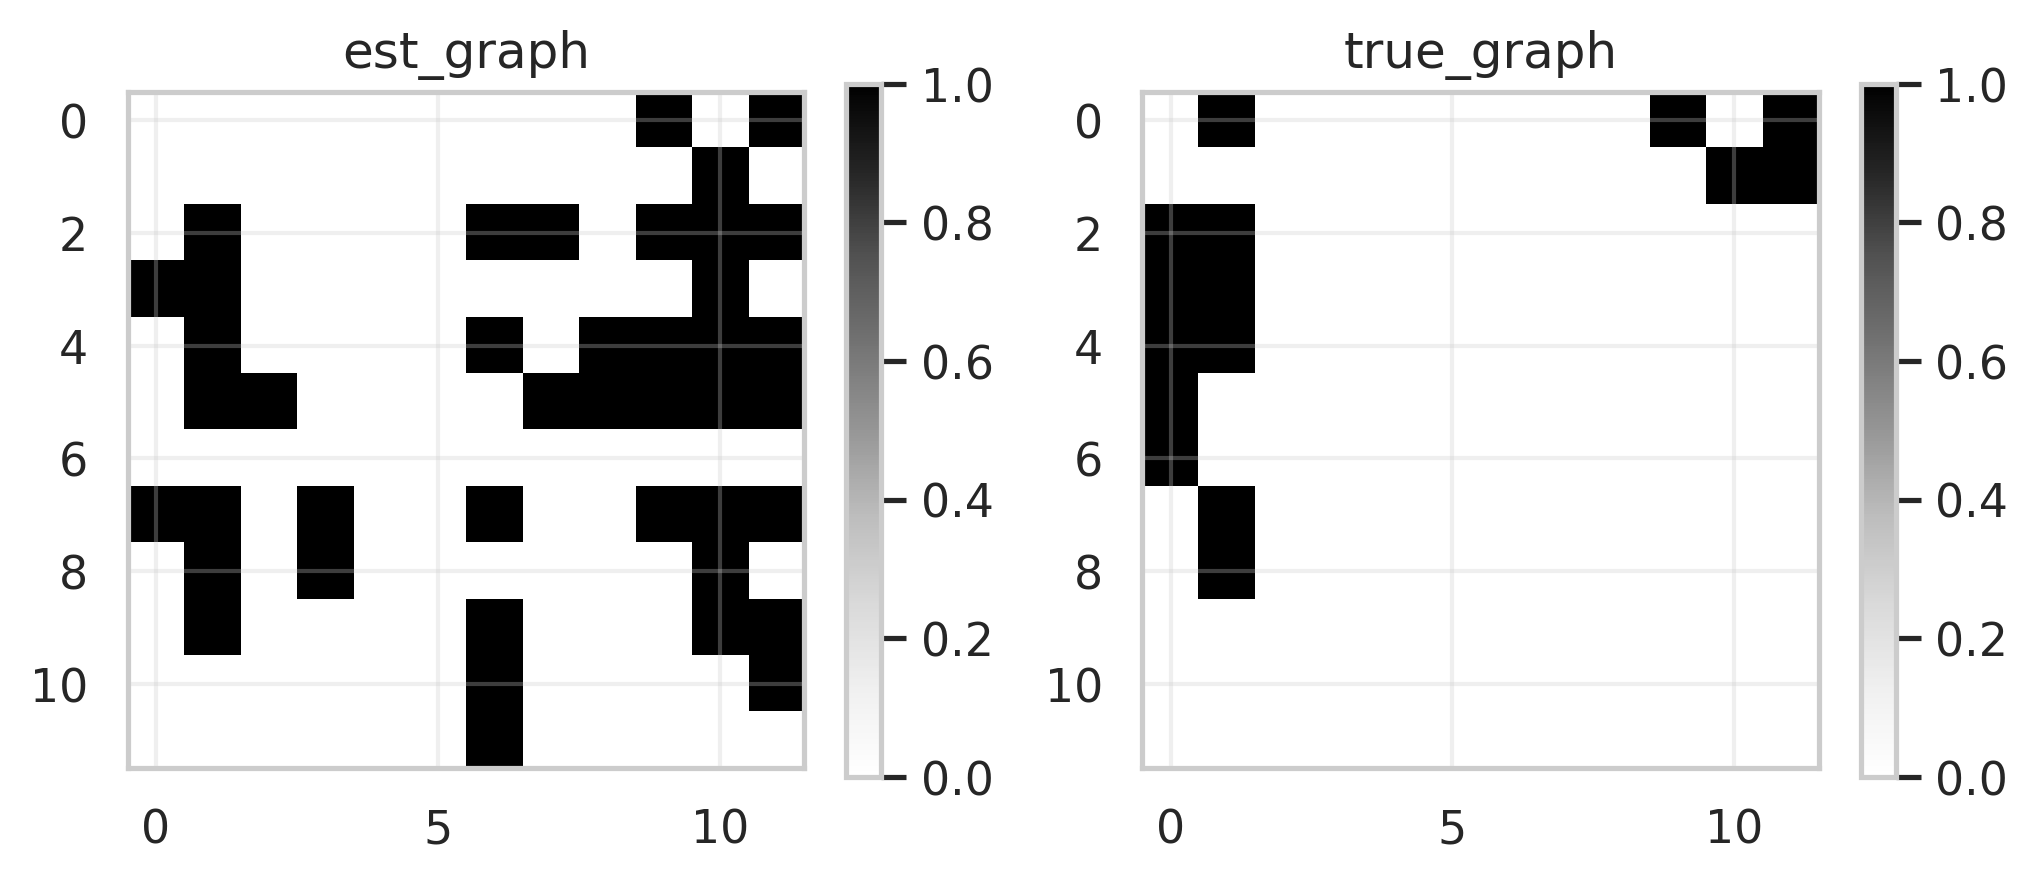

{'fdr': 0.7857, 'tpr': 0.6, 'fpr': 0.6471, 'shd': 39, 'nnz': 42, 'precision': 0.2143, 'recall': 0.6, 'F1': 0.3158, 'gscore': 0.0}


: 

In [ ]:
# LiM from lingam library
lim = lingam.LiM(w_threshold=0.3, max_iter=100, h_tol=1e-8, rho_max=1e12, lambda1=1e-2, seed=seed) # default rho_max is 1e16
# create array of shape (1, n_features) which indicates which columns/variables in data.values are discrete or continuous variables, where "1" indicates a continuous variable, while "0" a discrete variable.
is_cont = np.array([(1 if X_df[col].nunique() > 2 else 0) for col in X_df.columns]).reshape(1, -1)
#LiM.fit(X=X, dis_con=is_cont, only_global=False) # does not finish, even fater 375 minutes
lim.fit(X=X, dis_con=is_cont, only_global=True)

# plot est_dag and true_dag
W_est_lim = np.array(lim.adjacency_matrix_)
B_est_lim = compute_binary_adjacency(W_est_lim)

GraphDAG(B_est_lim, B_true)

# calculate accuracy
met_lim = MetricsDAG(B_est_lim, B_true)
print(met_lim.metrics)

In [ ]:
### imports
import os
import csv
import logging
import multiprocessing
from multiprocessing import Pool
import networkx as nx
import numpy as np
import pandas as pd

from abc import ABC, abstractmethod
from datetime import datetime
from itertools import combinations, product, chain
from math import floor
from multiprocessing import Pool, RawArray
from scipy.spatial import KDTree
from scipy.special import digamma
from scipy.stats import rankdata

### manual added implementation of mCMIkNN

class IndependenceTest(ABC):

    @abstractmethod
    def test_params(self):
        pass

    @abstractmethod
    def compute_pval(self, x, y, z):
        pass
    
class mCMIkNN(IndependenceTest):
    '''
        An independence test class that provides acces to the following non-parametric methods described in Huegle et al. (2022)
        - compute_mi: non-parametric estimator for mutual information I(X;Y)
        - compute_cmi: non-parametric estimator for conditional mutual information I(X;Y|Z)
        - compute_pval_mi: non-parametric independence test returning p value for H_0: X _||_ Y
        - compute_pval: non-parametric conditional independence test returing p value for H_0: X _||_ Y | Z
    '''
    def __init__(self,
                 kcmi=25,
                 kperm=5,
                 Mperm=100,
                 seed=42,
                 subsample=None,
                 transform=None,
                 log_warning=False):

        # Required parameters with defaults
        self.Mperm = Mperm
        self.kcmi = kcmi
        self.kperm = kperm
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)  # Initialize RNG with seed
        # Persisted values
        self.cmi_val = None
        self.null_distribution = None
        self.permutation = None
        self.pval = None
        # Options
        self.transform = transform
        self.dis = 10
        self.subsample = subsample
        self.leafsize = 16
        self.log_warning = log_warning

    def test_params(self):
        return {
            'kcmi': self.kcmi,
            'kperm':self.kperm,
            'Mperm': self.Mperm,
            'Transformation': self.transform,
        }

    def rank_transform(self, x, y, z=None):
        '''
            Rank Transform all variables while preserving rank of discrete points.
        '''
        x_transformed = rankdata(x, method='dense', axis=0).astype(np.float32)
        y_transformed = rankdata(y, method='dense', axis=0).astype(np.float32)
        z_transformed = None if np.all(z) == None else rankdata(z, method='dense', axis=0).astype(np.float32)
        return (x_transformed, y_transformed, z_transformed)

    def uniform_transform(self, x, y, z=None):
        '''
            Transform all variables to take values in [0,1] with equal distances while preserving discrete points (i.e., normalized rank transformed variables).
        '''
        x_transformed = self.normalize(rankdata(x, method='dense', axis=0).astype(np.float32))
        y_transformed = self.normalize(rankdata(y, method='dense', axis=0).astype(np.float32))
        z_transformed = None if np.all(z) == None else self.normalize(rankdata(z, method='dense', axis=0).astype(np.float32))
        return (x_transformed, y_transformed, z_transformed)

    def standardize(self, x):
        x_mean = np.mean(x, axis=0)
        x_std = np.std(x, axis=0)
        return (x - x_mean) / x_std

    def standard_transform(self, x, y, z=None):
        '''
            Standardize all continuous variables (unique values > 10) to std. normal distribution,
            i.e., (x-mean(x))/std(x)
        '''
        res = []
        # Standardize Xa if unique(Xa) > 10
        xN = []
        for a in x.T:
            if np.unique(a, axis=0).shape[0] > self.dis:
                xN.append(self.standardize(a))
            else:
                xN.append(a)
        res.append(np.asarray(xN).T)

        # Standardize Ya if unique(Ya) > 10
        yN = []
        for a in y.T:
            if np.unique(a, axis=0).shape[0] > self.dis:
                yN.append(self.standardize(a))
            else:
                yN.append(a)
        res.append(np.asarray(yN).T)

        # Standardize Za if unique(Za) > 10
        zN = []
        if np.all(z) != None:
            for a in z.T:
                if np.unique(a, axis=0).shape[0] > self.dis:
                    zN.append(self.standardize(a))
                else:
                    zN.append(a)
            res.append(np.asarray(zN).T)
        else:
            res.append(None)
        return res

    def normalize(self, x):
        x_min = np.min(x, axis=0)
        x_max = np.max(x, axis=0)
        return (x-x_min)/(x_max-x_min)

    def normal_transform(self, x, y, z=None):
        '''
            Normalize all continuous variables (unique values > 10) to take values in [0,1],
            i.e., (x-min(x))/(max(x)-min(x))
        '''
        res = []
        # Normalize Xa if unique(Xa) > 10
        xN = []
        for a in x.T:
            if np.unique(a, axis=0).shape[0] > self.dis:
                xN.append(self.normalize(a))
            else:
                xN.append(a)
        res.append(np.asarray(xN).T)

        # Normalize Ya if unique(Ya) > 10
        yN = []
        for a in y.T:
            if np.unique(a, axis=0).shape[0] > self.dis:
                yN.append(self.normalize(a))
            else:
                yN.append(a)
        res.append(np.asarray(yN).T)

        # Normalize Za if unique(Za) > 10
        zN = []
        if np.all(z) != None:
            for a in z.T:
                if np.unique(a, axis=0).shape[0] > self.dis:
                    zN.append(self.normalize(a))
                else:
                    zN.append(a)
            res.append(np.asarray(zN).T)
        else:
            res.append(None)
        return res

    def transform_data(self, x, y, z=None):
        if self.transform == 'rank':
            return self.rank_transform(x, y, z)
        elif self.transform == 'standardize':
            return self.standard_transform(x, y, z)
        elif self.transform == 'normalize':
            return self.normal_transform(x, y, z)
        elif self.transform == 'uniform':
            return self.uniform_transform(x, y, z)
        return (x, y, z)

    def count_NN(self, tree, points, rho):
        '''
            Count all nearest neighbors with distance smaller or equal to rho. (Note, this does not include point itself.)
        '''
        return tree.query_ball_point(points, rho, p=np.inf, return_length=True)-1


    def return_NN(self, tree, points, sigma):
        '''
            Return all nearest neighbors with distance smaller or equal to sigma. (Note, excludes point itself.)
        '''
        # includes points itself
        neighbors = tree.query_ball_point(points, sigma, p=np.inf)
        # exclude points withing neighborhood
        for i in range(len(points)):
            neighbors[i].remove(i)

        return neighbors


    def compute_mi(self, x, y):
        '''
            Estimate the mutual information I(X;Y) of X and Y from n samples (x_i, y_i)_{i=1}^n
            using Alg. 1 which relates to the *Mixed-KSG* mutual information estimator of Gao et al. (2017)

            Note: Using digamma instead of log according to Mesner et al. (2021)

            Input:  x: 2D array of size n*dz (or 1D list of size n if dx = 1)
                    y: 2D array of size n*dz (or 1D list of size n if dy = 1)
                    (self.kcmi: k-nearest neighbor parameter)

            Output: ^I_n(X;Y)
        '''
        assert len(x) == len(y), "x and y should have the same number of observations"
        n = len(x)
        assert self.kcmi <= n-1, "Set kcmi smaller than number of observations - 1"

        x =  x.reshape((n, 1)).astype(np.float32) if (x.shape == (n,)) else x.astype(np.float32)
        y =  y.reshape((n, 1)).astype(np.float32) if (y.shape == (n,)) else y.astype(np.float32)
        xy = np.concatenate((x, y), axis=1)

        # build k-d trees
        tree_xy = KDTree(xy, leafsize=self.leafsize)
        tree_x = KDTree(x, leafsize=self.leafsize)
        tree_y = KDTree(y, leafsize=self.leafsize)

        # compute k-NN distances, using k+1 as this includes dist to self
        rho = tree_xy.query(xy, self.kcmi+1, p=np.inf)[0][:, self.kcmi]

        # if continous  -> k_tilde = k_cmi
        # if discrete or mixed -> k_tilde = number of samples with distance rho
        k_tilde = self.count_NN(tree_xy, xy, rho)

        # entropy estimates - i.e., count points withon distance rho
        nx = self.count_NN(tree_x, x, rho)
        ny = self.count_NN(tree_y, y, rho)

        mi = np.mean(digamma(k_tilde) + digamma(n) - digamma(nx) - digamma(ny))
        return max(0,mi)

    def compute_cmi(self, x, y, z):
        '''
            Estimate the conditional mutual information I(X;Y|Z) of X and Y given a dz-dimensional variable Z from samples (x_i, y_i,z_i)_{i=1}^n
            Using Alg. 1 which relates to the *Mixed-KSG* mutual information estimator of Mesner et al. (2021)

            Input:  x: 2D array of size n*dz (or 1D list of size n if dx = 1)
                    y: 2D array of size n*dz (or 1D list of size n if dy = 1)
                    z: 2D array of size n*dz (or 1D list of size n if dz = 1)
                    (self.kcmi: k-nearest neighbor parameter)

            Output: ^I_n(X;Y|Z)
        '''
        assert len(x) == len(y) == len(z), "x, y, and z should have same number of observations"
        n=len(x)
        assert self.kcmi <= n-1, "Set kcmi smaller than number of observations - 1"

        x =  x.reshape((n, 1)).astype(np.float32) if (x.shape == (n,)) else x.astype(np.float32)
        y =  y.reshape((n, 1)).astype(np.float32) if (y.shape == (n,)) else y.astype(np.float32)
        z =  z.reshape((n, 1)).astype(np.float32) if (z.shape == (n,)) else z.astype(np.float32)

        yz = np.concatenate((y, z), axis=1)
        xyz = np.concatenate((x, yz), axis=1)
        xz = np.concatenate((x, z), axis=1)

        # build k-d trees
        tree_xyz = KDTree(xyz, leafsize= self.leafsize)
        tree_xz = KDTree(xz, leafsize= self.leafsize)
        tree_yz = KDTree(yz, leafsize= self.leafsize)
        tree_z = KDTree(z, leafsize= self.leafsize)

        # compute k-NN distances, using k+1 as this includes dist to self
        rho = tree_xyz.query(xyz, self.kcmi+1, p=np.inf)[0][:, self.kcmi]

        # if continous  -> k_tilde = k_cmi
        # if discrete or mixed -> k_tilde = number of samples with distance rho
        k_tilde = self.count_NN(tree_xyz, xyz, rho)

        # entropy estimates - i.e., count neighbors within distance rho
        nxz = self.count_NN(tree_xz, xz, rho)
        nyz = self.count_NN(tree_yz, yz, rho)
        nz = self.count_NN(tree_z, z, rho)

        cmi = np.mean(digamma(k_tilde) - digamma(nxz) - digamma(nyz) + digamma(nz))
        return max(0,cmi)

    def compute_pval_mi(self, x, y):
        '''
            Returns the p value returning p value for H_0: X _||_ Y estimated from n samples (x_i, y_i)_{i=1}^n
            using Alg. 2 of Huegle et al. (2022), i.e., comparing the present MI against MIs for shuffled samples of X under H_0.

            H_0: X and Y are independent
            H_1: X and Y are dependent

            Note: Using rank transformation for k-NN searches according to Runge (2017) but preserving ties

            Input:  x: 2D array of size n*dz (or 1D list of size n if dx = 1)
                    y: 2D array of size n*dz (or 1D list of size n if dy = 1)
                    (self.Mperm: number of permutations)
                    (self.kcmi: k used for MI estimation)

            Output: p_perm,n
        '''

        assert len(x) == len(y), "x and y should have same number of observations"

        if self.subsample is not None:
            sample = np.random.choice(np.arange(len(x)), min(len(x), self.subsample), replace=False)
            x, y = x[sample], y[sample]

        n = len(x)

        x =  x.reshape((n, 1)).astype(np.float32) if (x.shape == (n,)) else x.astype(np.float32)
        y =  y.reshape((n, 1)).astype(np.float32) if (y.shape == (n,)) else y.astype(np.float32)

        x, y, _ = self.transform_data(x,y)

        n = len(x)
        if self.kperm == 0:
            self.kperm = np.floor(np.sqrt(n)).astype(int)
        elif 0 < self.kperm <= 1:
            self.kperm = np.floor(np.nextafter(self.kperm,0) * n).astype(int) # ensure kperm < n (n-1 equals shuffling without considering z)

        if self.kcmi == 0:
            self.kcmi = np.floor(np.sqrt(n)).astype(int)
        elif 0 < self.kcmi <= 1:
            self.kcmi = np.floor(np.nextafter(self.kcmi,0) * n).astype(int) # ensure kcmi < n

        # estimate present MI value
        self.cmi_val = self.compute_mi(x, y)

        # estimate Mperm MIs for shuffled X under H_0
        null_dist = np.zeros(self.Mperm)
        for m in range(self.Mperm):
             # Generate random shuffled x
            x_shuffled = x[self.rng.permutation(n)]
            null_dist[m] = self.compute_mi(x_shuffled, y)

        # estimate pvalue comparing MI against MIs for shuffled X
        self.null_distribution = null_dist
        self.pval = (1+np.sum(null_dist >= self.cmi_val))/(1+self.Mperm)
        return self.pval

    def compute_pval(self, x, y, z=None):
        '''
            Returns the p value returning p value for H_0: X _||_ Y | Z estimated from n samples (x_i, y_i,z_i)_{i=1}^n
            using Alg. 2 of Huegle et al. (2022), i.e., comparing the present MI against MIs for shuffled samples of X under H_0.

            H_0: X and Y are independent given dz dimensional Z
            H_1: X and Y are dependent given dz dimensional Z

            Note: Using rank transformation for k-NN searches according to Runge (2017) but preserving ties

            Input:  x: 1D 2D array of size n*dz (or 1D list of size n if dx = 1)
                    y: 1D 2D array of size n*dz (or 1D list of size n if dy = 1)
                    z: 2D array of size n*dz (or 1D list of size n if dz = 1)
                    (self.Mperm: number of permutations)
                    (self.kperm: k used for local permuation scheme)
                    (self.kcmi: k used for MI estimation)

            Output: p_perm,n
        '''

        # for empty z calculate return p value according to H_0: X _||_ Y
        if z is None:
            return self.compute_pval_mi(x, y)

        assert len(x) == len(y) == len(z), "x, y, and z should have same number of observations"

        if self.subsample is not None:
            sample = np.random.choice(np.arange(len(x)), min(len(x), self.subsample), replace=False)
            x, y, z = x[sample], y[sample], z[sample]

        n = len(x)

        x =  x.reshape((n, 1)).astype(np.float32) if (x.shape == (n,)) else x.astype(np.float32)
        y =  y.reshape((n, 1)).astype(np.float32) if (y.shape == (n,)) else y.astype(np.float32)
        z =  z.reshape((n, 1)).astype(np.float32) if (z.shape == (n,)) else z.astype(np.float32)
        x, y, z = self.transform_data(x, y, z)

        if self.kperm == 0:
            self.kperm = np.floor(np.sqrt(n)).astype(int)
        elif 0 < self.kperm <= 1:
            self.kperm = np.floor(np.nextafter(self.kperm,0) * n).astype(int) # ensure kperm < n (n-1 equals shuffling without considering z)

        if self.kcmi == 0:
            self.kcmi = np.floor(np.sqrt(n)).astype(int)
        elif 0 < self.kcmi <= 1:
            self.kcmi = np.floor(np.nextafter(self.kcmi,0) * n).astype(int) # ensure kcmi < n

        # estimate present CMI value
        self.cmi_val = self.compute_cmi(x, y, z)

        # Get nearest neighbors around each sample point in Z
        tree_z = KDTree(z, leafsize= self.leafsize)

        # compute k-NN distances in Z, using k+1 as this includes dist to self
        sigma = tree_z.query(z, self.kperm+1, p=np.inf)[0][:, self.kperm]

        # if continuous -> k points distance smaller or equal to sigma excluding the point itself
        # if discrete or mixed -> all points with distance smaller or euqla to the k-NN distance sigma excluding the point itself
        neighbors = self.return_NN(tree_z, z, sigma)

        # estimate Mperm CMIs for shuffled X under H_0 while preserving marginal distributions
        null_dist = np.zeros(self.Mperm)
        for m in range(self.Mperm):
            # compose local permutations of nearest neighbors to receive a restricted permutation of the whole index list
            permutation = np.arange(n)
            for i in range(n-1,-1,-1):
                permutation[neighbors[i,]]=permutation[self.rng.permutation(neighbors[i,])]
            x_shuffled = x[permutation]
            null_dist[m] = self.compute_cmi(x_shuffled, y, z)

        self.null_distribution = null_dist
        self.pval = (1+np.sum(null_dist >= self.cmi_val))/(1+self.Mperm)
        return self.pval

### parallel pc alg
# A global dictionary storing the variables passed from the initializer.
var_dict = {}

def _init_worker(data, data_shape, graph, vertices, test, alpha):
    # Using a dictionary is not strictly necessary. You can also
    # use global variables.
    var_dict['data'] = data
    var_dict['data_shape'] = data_shape

    var_dict['graph'] = graph
    var_dict['vertices'] = vertices

    var_dict['alpha'] = alpha
    var_dict['test'] = test

def _test_worker(i, j, lvl):
    test = var_dict['test']
    alpha = var_dict['alpha']
    data_arr = np.frombuffer(var_dict['data']).reshape(var_dict['data_shape'])
    graph = np.frombuffer(var_dict['graph'], dtype="int32").reshape((var_dict['vertices'],
                                                                     var_dict['vertices']))
    
    # unconditional
    if lvl < 1:
        p_val = test.compute_pval(data_arr[:, [i]], data_arr[:, [j]], z=None)
        if (p_val > alpha):
            return (i, j, p_val, [])
    # conditional
    else:
        candidates_1 = np.arange(var_dict['vertices'])[(graph[i] == 1)]
        candidates_1 = np.delete(candidates_1, np.argwhere((candidates_1==i) | (candidates_1==j)))

        if (len(candidates_1) < lvl):
            return None
        
        for S in [list(c) for c in combinations(candidates_1, lvl)]:
            p_val = test.compute_pval(data_arr[:, [i]], data_arr[:, [j]], z=data_arr[:, list(S)])
            if (p_val > alpha):
                return (i, j, p_val, list(S))
            
    return None

def _unid(g, i, j):
    return g.has_edge(i, j) and not g.has_edge(j, i)

def _bid(g, i, j):
    return g.has_edge(i, j) and g.has_edge(j, i)

def _adj(g, i, j):
    return g.has_edge(i, j) or g.has_edge(j, i)

def rule1(g, j, k):
    for i in g.predecessors(j):
        # i -> j s.t. i not adjacent to k
        if _unid(g, i, j) and not _adj(g, i, k):
            g.remove_edge(k, j)
            return True
    return False

def rule2(g, i, j):
    for k in g.successors(i):
        # i -> k -> j
        if _unid(g, k, j) and _unid(g, i, k):
            g.remove_edge(j, i)
            return True
    return False

def rule3(g, i, j):
    for k, l in combinations(g.predecessors(j), 2):
        # i <-> k -> j and i <-> l -> j s.t. k not adjacent to l
        if (not _adj(g, k, l) and _bid(g, i, k) and _bid(g, i, l) and _unid(g, l, j) and _unid(g, k, j)):
            g.remove_edge(j, i)
            return True
    return False

def rule4(g, i, j):
    for l in g.predecessors(j):
        for k in g.predecessors(l):
            # i <-> k -> l -> j s.t. k not adjacent to j and i adjacent to l
            if (not _adj(g, k, j) and _adj(g, i, l) and _unid(g, k, l) and _unid(g, l, j) and _bid(g, i, k)):
                g.remove_edge(j, i)
                return True
    return False

def _direct_edges(graph, sepsets):
    digraph = nx.DiGraph(graph)
    for i in graph.nodes():
        for j in nx.non_neighbors(graph, i):
            for k in nx.common_neighbors(graph, i, j):
                sepset = sepsets[(i, j)] if (i, j) in sepsets else []
                if k not in sepset:
                    if (k, i) in digraph.edges() and (i, k) in digraph.edges():
                        digraph.remove_edge(k, i)
                    if (k, j) in digraph.edges() and (j, k) in digraph.edges():
                        digraph.remove_edge(k, j)

    bidirectional_edges = [(i, j) for i, j in digraph.edges if digraph.has_edge(j, i)]
    for i, j in bidirectional_edges:
        if _bid(digraph, i, j):
            continue
        if (rule1(digraph, i, j) or rule2(digraph, i, j) or rule3(digraph, i, j) or rule4(digraph, i, j)):
            continue

    return digraph

def parallel_stable_pc(data, estimator, alpha=0.05, processes=1, max_level=None):
    """
    Perform the Parallel Stable PC algorithm for causal discovery.

    Parameters:
    data (pd.DataFrame): The input data as a pandas DataFrame.
    estimator: The conditional independence (CI) test to be used.
    alpha (float): The significance level for the CI tests. Default is 0.05.
    processes (int): The number of processes to use for parallel computation. Default is 1.
    max_level (int or None): The maximum level of the PC algorithm. If None, no limit is set. Default is None.

    Returns:
    nx.DiGraph: The directed graph discovered by the algorithm.
    dict: The separation sets for the discovered edges.
    """
    cols = data.columns
    cols_map = np.arange(len(cols))

    data_raw = RawArray('d', data.shape[0] * data.shape[1])
    # Wrap X as an numpy array so we can easily manipulates its data.
    data_arr = np.frombuffer(data_raw).reshape(data.shape)
    # Copy data to our shared array.
    np.copyto(data_arr, data.values)

    # same magic as for data
    vertices = len(cols)
    graph_raw = RawArray('i', np.ones(vertices*vertices).astype(int))
    graph = np.frombuffer(graph_raw, dtype="int32").reshape((vertices, vertices))
    sepsets = {}

    lvls = range((len(cols) - 1) if max_level is None else min(len(cols)-1, max_level+1))
    for lvl in lvls:
        configs = [(i, j, lvl) for i, j in product(cols_map, cols_map) if i != j and graph[i][j] == 1]

        logging.info(f'Starting level {lvl} pool with {len(configs)} remaining edges at {datetime.now()}')
        with Pool(processes=processes, initializer=_init_worker,
                  initargs=(data_raw, data.shape, graph_raw, vertices, estimator, alpha)) as pool:
            result = pool.starmap(_test_worker, configs)

        for r in result:
            if r is not None:
                graph[r[0]][r[1]] = 0
                graph[r[1]][r[0]] = 0
                sepsets[(r[0], r[1])] = {'p_val': r[2], 'sepset': r[3]}

    nx_graph = nx.from_numpy_array(graph)
    nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
    nx_digraph = _direct_edges(nx_graph, sepsets)
    nx.relabel_nodes(nx_digraph, lambda i: cols[i], copy=False)
    sepsets = {(cols[k[0]], cols[k[1]]): {'p_val': v['p_val'], 'sepset': [cols[e] for e in v['sepset']]}
               for k, v in sepsets.items()}

    return nx_digraph, sepsets

### parameters
alpha = 0.2# significance level, increasing it will increase the number of edges
processes = 100 # set number of cores
# set mCMIkNN parameters
kcmi = 25 # number of nearest neighbors to find for mutual information estimation
kperm = 5 # neighborhood size for local permutation scheme
Mperm = 100 # linear reduction in computational cost, total number of permutations to compute for p-value estimation
#subsample = 1000 # 2 mins
subsample = 500 # 1 min
# set maximum level of pcalg (None == infinite)
max_level = None # limits the maximum size of the conditioning set

# Create an instance of the mCMIkNN class
indep_test = mCMIkNN(kcmi=kcmi, kperm=kperm, Mperm=Mperm, subsample=subsample, seed=seed)

# Run the parallel_stable_pc algorithm
graph, sepsets = parallel_stable_pc(X_df, indep_test, alpha=alpha, processes=processes, max_level=max_level)

# plot est_dag and true_dag
B_est_mcmiknn = nx.to_numpy_array(graph)

GraphDAG(B_est_mcmiknn, B_true)

# calculate accuracy
met_mcmiknn = MetricsDAG(B_est_mcmiknn, B_true)

print(met_mcmiknn.metrics)

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the true graph: {np.sum(B_true)}")
print(f"The number of edges in the estimated graph: {np.sum(B_est_mcmiknn)}")

In [ ]:
###### PLACE METRIC COMPUTATION CODE HERE ######

# Define models and their corresponding adjacency/weight matrices
models = {
    "Our (PC)": (B_est, W_est),
    "Peter Clark": (B_est_pc, None),  # PC based
    "NOTEARS": (B_est_nt, W_est_nt),
    "ICALiNGAM": (B_est_icalingam, W_est_icalingam),
    "LiM": (B_est_lim, W_est_lim),
    "mCMIkNN": (B_est_mcmiknn, None),  # PC based
}

# Indices for treatment (intervention) and target variables
interv_node_idx = 0
target_node_idx = 11

# Store results as a list of dictionaries (one per method)
results = []

for model_name, (B, W) in models.items():
    B_binary = (enforce_dag(B) > 0).astype(np.int8)  # Convert adjacency to binary

    result = {
        "seed": seed,
        "method": model_name,
        "SHD_absolute": compute_SHD((B_true > 0).astype(np.int8), B_binary)[1],
        "SHD_normalized": compute_SHD((B_true > 0).astype(np.int8), B_binary)[0],
        "SID_absolute": compute_SID((B_true > 0).astype(np.int8), B_binary)[1],
        "SID_normalized": compute_SID((B_true > 0).astype(np.int8), B_binary)[0],
        "AID_absolute": compute_ancestor_AID((B_true > 0).astype(np.int8), B_binary)[1],
        "AID_normalized": compute_ancestor_AID((B_true > 0).astype(np.int8), B_binary)[0],
        "F1_Score": compute_F1_directed(B_true, B),
    }

    # Compute Total Effect Estimation Error (TEE), AUROC, and AUPRC (if weights exist)
    if W is not None:
        true_effect, est_effect, tee = compute_TEE(W_true, W, interv_node_idx, target_node_idx)
        _B_true = (np.abs(W_true) > 0).astype(int)

        result.update({
            "TEE": tee,
            "AUROC": compute_AUROC(_B_true, W)[-1],
            "AUPRC": compute_AUPRC(_B_true, W)[-1],
            "True_Total_Effect": true_effect,
            "Estimated_Total_Effect": est_effect,
        })
    else:
        result.update({"TEE": None, "AUROC": None, "AUPRC": None, "True_Total_Effect": None, "Estimated_Total_Effect": None})

    results.append(result)  # Append results for each model separately


In [ ]:
##################################################### EVALUATION METRICS #####################################################

In [ ]:
def evaluate_model(B_true, B_est, interv_node_idx, target_node_idx, model_name):

    # Convert adjacency matrices to binary (int8) for compatibility with `gadjid` metrics
    B_true_binary = (B_true > 0).astype(np.int8)
    B_est_binary = (B_est > 0).astype(np.int8)

    # Compute Structural Hamming Distance (SHD)
    SHD_normalized, SHD_absolute = compute_SHD(B_true_binary, B_est_binary)
    print(f"{model_name} - Structural Hamming Distance (SHD): {SHD_absolute}")
    print(f"{model_name} - Normalized SHD: {SHD_normalized}")

    # Compute Parent Adjustment Distance (SID)
    SID_normalized, SID_absolute = compute_SID(B_true_binary, B_est_binary)
    print(f"{model_name} - Structural Intervention Distance (SID): {SID_absolute}")
    print(f"{model_name} - Normalized SID: {SID_normalized}")

    # Compute Ancestor Adjustment Distance (AID)
    AID_normalized, AID_absolute = compute_ancestor_AID(B_true_binary, B_est_binary)
    print(f"{model_name} - Ancestor Adjustment Distance (AID): {AID_absolute}")
    print(f"{model_name} - Normalized AID: {AID_normalized}")

    # Compute F1 score
    F1_our = compute_F1_directed(B_true, B_est)
    print(f"{model_name} - F1 Score: {F1_our}")

def evaluate_effect(W_true, W_est, interv_node_idx, target_node_idx, model_name):
    # Compute Total Effect Estimation Error (TEE)
    true_total_effect, est_total_effect, TEE = compute_TEE(W_true, W_est, interv_node_idx, target_node_idx)
    _B_true = (np.abs(W_true) > 0).astype(int)
    auroc, auprc = compute_AUROC(_B_true, W_est)[-1], compute_AUPRC(_B_true, W_est)[-1]
    print(f"{model_name} - AUROC: {auroc}")
    print(f"{model_name} - AUPRC: {auprc}")
    print(f"{model_name} - True Total Effect: {true_total_effect}")
    print(f"{model_name} - Estimated Total Effect: {est_total_effect}")
    print(f"{model_name} - Total Effect Estimation Error (TEE): {TEE}")

# Example usage
# Indices for treatment (intervention) and target variables
interv_node_idx = 0
target_node_idx = 11

# our model
evaluate_model(B_true, B_est, interv_node_idx, target_node_idx, "Our (PC)")
print()
evaluate_effect(W_true, W_est, interv_node_idx, target_node_idx, "Our (PC)")


In [ ]:
is_dag_nx(enforce_dag(B_est_pc))

In [ ]:
# PC
evaluate_model(B_true, enforce_dag(B_est_pc), interv_node_idx, target_node_idx, "Peter Clark")

In [ ]:
# notears
evaluate_model(B_true, enforce_dag(B_est_nt), interv_node_idx, target_node_idx, "NOTEARS")
print()
evaluate_effect(W_true, W_est_nt, interv_node_idx, target_node_idx, "NOTEARS")

In [ ]:
# icalingam
evaluate_model(B_true, B_est_icalingam, interv_node_idx, target_node_idx, "ICALiNGAM")
print()
evaluate_effect(W_true, W_est_icalingam, interv_node_idx, target_node_idx, "ICALiNGAM")

In [ ]:
# lim
evaluate_model(B_true, B_est_lim, interv_node_idx, target_node_idx, "LiM")

In [ ]:
# mcmiknn
evaluate_model(B_true, B_est_mcmiknn, interv_node_idx, target_node_idx, "mCMIkNN")

In [ ]:
################################ MISC MODELS AND CODE ################################

In [ ]:
# GES learn
# method is one of ['r2', 'scatter']
ges = GES() # F1 of 47%
#ges = GES(criterion='bic', method='scatter') # F1 of 47%
#ges = GES(criterion='bic', method='r2') # F1 of 4%

# learn the graph structure
ges.learn(X)

# plot est_dag and true_dag
GraphDAG(ges.causal_matrix, B_true)

# calculate accuracy
ges_met = MetricsDAG(ges.causal_matrix, B_true)
print(ges_met.metrics)

# DirectLiNGAM learn
# measure : {'pwling', 'kernel'}, default='pwling'
g_dlingam = DirectLiNGAM(measure='pwling') # F1 of 74%
#g = DirectLiNGAM(measure='kernel') # F1 of nan - takes too long to run (even after 15 minutes not done)
g_dlingam.learn(X)

# plot est_dag and true_dag
GraphDAG(g_dlingam.causal_matrix, B_true)

# calculate accuracy
g_dlingam_met = MetricsDAG(g_dlingam.causal_matrix, B_true)
print(g_dlingam_met.metrics)

In [ ]:
import networkx as nx
import numpy as np

